# Importação e Leitura

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from math import ceil, sqrt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    mean_absolute_error, 
    mean_squared_error,
    silhouette_score,
    make_scorer
)

from scipy import stats
from scipy.stats import chi2_contingency

import duckdb

In [2]:
df = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")
df

/tmp/ipykernel_37562/203287006.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.621790,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212907,10/09/2016,9:30,STATEN ISLAND,10305.0,40.612595,-74.071655,"(40.612595, -74.071655)",NaN,NaN,254 CLIFTON AVENUE,...,NaN,NaN,NaN,NaN,3536789,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
2212908,09/20/2016,12:30,BROOKLYN,11229.0,40.610725,-73.955574,"(40.610725, -73.955574)",NaN,NaN,1804 AVENUE P,...,Unspecified,NaN,NaN,NaN,3527277,Sedan,Sedan,NaN,NaN,NaN
2212909,09/19/2016,13:00,NaN,NaN,40.611767,-73.976380,"(40.611767, -73.97638)",24 AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,3523434,Sedan,NaN,NaN,NaN,NaN
2212910,09/28/2016,11:20,NaN,NaN,40.620560,-73.989440,"(40.62056, -73.98944)",63 STREET,NaN,NaN,...,Unspecified,NaN,NaN,NaN,3529408,Station Wagon/Sport Utility Vehicle,Pick-up Truck,NaN,NaN,NaN


## Verificando nulos

In [3]:
df.isnull().sum().sum() # Muitos valores nulos impossivel exclui-los

np.int64(18922504)

In [4]:
df.isna().sum() # colunas off street name, contributing factor 3 veicle ate o 5 , vehicle type code 3 ate o 5 sao colunas com muitos valores nulos
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

VEHICLE TYPE CODE 5              99.561799
CONTRIBUTING FACTOR VEHICLE 5    99.547564
VEHICLE TYPE CODE 4              98.408116
CONTRIBUTING FACTOR VEHICLE 4    98.348556
VEHICLE TYPE CODE 3              93.045860
CONTRIBUTING FACTOR VEHICLE 3    92.765325
OFF STREET NAME                  82.421352
CROSS STREET NAME                38.204095
ZIP CODE                         30.683687
BOROUGH                          30.671260
ON STREET NAME                   21.752966
VEHICLE TYPE CODE 2              20.007935
CONTRIBUTING FACTOR VEHICLE 2    16.022553
LOCATION                         10.858679
LATITUDE                         10.858679
LONGITUDE                        10.858679
VEHICLE TYPE CODE 1               0.723797
CONTRIBUTING FACTOR VEHICLE 1     0.352070
NUMBER OF PERSONS KILLED          0.001401
NUMBER OF PERSONS INJURED         0.000813
CRASH DATE                        0.000000
NUMBER OF PEDESTRIANS INJURED     0.000000
CRASH TIME                        0.000000
NUMBER OF M

# Lidando Com Outliers

In [5]:
# Converte os outliars de longitude e latitude em Nan
# lat_min, lat_max = 40.49, 40.92
# lon_min, lon_max = -74.26, -73.69
# filtro_invalidas = (
#     (df['LATITUDE'] < lat_min) | (df['LATITUDE'] > lat_max) |
#     (df['LONGITUDE'] < lon_min) | (df['LONGITUDE'] > lon_max)
# )
# df.loc[filtro_invalidas, ['LATITUDE', 'LONGITUDE']] = np.nan

## Lidando Com Missing Values

In [6]:
# df.info()

In [7]:
print("Padronização de Texto e Imputação de Coordenadas")

# 1. Padronização de Texto
text_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'BOROUGH']

print("Padronizando nomes de ruas para maiúsculo...")
for col in text_cols:
    # Converte para upper e remove espaços
    df[col] = df[col].astype(str).str.upper().str.strip()
    df[col] = df[col].replace({'NAN': np.nan, 'NONE': np.nan})

missing_start = df['LATITUDE'].isna().sum()
print(f"\nNulos iniciais em LATITUDE: {missing_start:,}")

# PASSO 1: Interseção (Rua A & Rua B)
mask_intersection = (df['ON STREET NAME'].notna()) & (df['CROSS STREET NAME'].notna())
df.loc[mask_intersection, 'intersection_key'] = (
    df.loc[mask_intersection, 'ON STREET NAME'] + " & " + 
    df.loc[mask_intersection, 'CROSS STREET NAME']
)

print("1. Tentando imputar por Interseção...")
for col in ['LATITUDE', 'LONGITUDE']:
    df[col] = df[col].fillna(df.groupby('intersection_key')[col].transform('mean'))

# PASSO 2: Ruas Individuais
street_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']
for street_col in street_cols:
    print(f"2. Tentando imputar por '{street_col}'...")
    for col in ['LATITUDE', 'LONGITUDE']:
        df[col] = df[col].fillna(df.groupby(street_col)[col].transform('mean'))

# PASSO 3: ZIP CODE
if 'ZIP CODE' in df.columns:
    print("3. Tentando imputar por ZIP CODE...")
    for col in ['LATITUDE', 'LONGITUDE']:
        df[col] = df[col].fillna(df.groupby('ZIP CODE')[col].transform('mean'))

# Limpeza final
if 'intersection_key' in df.columns:
    df = df.drop(columns=['intersection_key'])

missing_end = df['LATITUDE'].isna().sum()
recovered = missing_start - missing_end

print(f"Total recuperado: {recovered:,} ({recovered/missing_start:.1%} dos nulos)")
print(f"Restantes sem coordenada: {missing_end:,}")

Padronização de Texto e Imputação de Coordenadas
Padronizando nomes de ruas para maiúsculo...

Nulos iniciais em LATITUDE: 240,293

Nulos iniciais em LATITUDE: 240,293
1. Tentando imputar por Interseção...
1. Tentando imputar por Interseção...
2. Tentando imputar por 'ON STREET NAME'...
2. Tentando imputar por 'ON STREET NAME'...
2. Tentando imputar por 'CROSS STREET NAME'...
2. Tentando imputar por 'CROSS STREET NAME'...
2. Tentando imputar por 'OFF STREET NAME'...
2. Tentando imputar por 'OFF STREET NAME'...
3. Tentando imputar por ZIP CODE...
3. Tentando imputar por ZIP CODE...
Total recuperado: 193,261 (80.4% dos nulos)
Restantes sem coordenada: 47,032
Total recuperado: 193,261 (80.4% dos nulos)
Restantes sem coordenada: 47,032


In [8]:
# Verifica o padrão dos que sobraram sem Latitude
missing_coords = df[df['LATITUDE'].isna()]

print("Ruas nos dados faltantes:")
print(missing_coords['ON STREET NAME'].value_counts().head())

print("\nZIP CODES nos dados faltantes:")
print(missing_coords['ZIP CODE'].value_counts().head())

Ruas nos dados faltantes:
ON STREET NAME
JACKIE ROBINSON PARKWAY    12
KING PLACE                 11
PLAZA DRIVE                11
MARGARET CORBIN DRIVE      11
W/B BELT PKWY               9
Name: count, dtype: int64

ZIP CODES nos dados faltantes:
ZIP CODE
10044.0    2
Name: count, dtype: int64


In [9]:
print("Limpeza Final e Filtragem Geográfica")

# 1. Criação do df_cleaned removendo linhas sem coordenada
df_cleaned = df.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()

# 2. Remove pontos que caíram fora
lat_min, lat_max = 40.49, 40.92
lon_min, lon_max = -74.26, -73.69

# Máscara para manter apenas o que está DENTRO de NYC
mask_nyc = (
    (df_cleaned['LATITUDE'] >= lat_min) & (df_cleaned['LATITUDE'] <= lat_max) &
    (df_cleaned['LONGITUDE'] >= lon_min) & (df_cleaned['LONGITUDE'] <= lon_max)
)

outliers = (~mask_nyc).sum()
df_cleaned = df_cleaned[mask_nyc].copy()

print(f"Outliers geográficos removidos: {outliers:,}")
print(f"Total final (df_cleaned): {len(df_cleaned):,}")

Limpeza Final e Filtragem Geográfica
Outliers geográficos removidos: 45,732
Total final (df_cleaned): 2,120,148
Outliers geográficos removidos: 45,732
Total final (df_cleaned): 2,120,148


In [10]:
from sklearn.neighbors import KNeighborsClassifier

print("Imputação de bairros via Coordenadas (KNN)")

# 1. Diagnóstico Inicial
missing_borough_start = df['BOROUGH'].isna().sum()
print(f"Nulos iniciais em BOROUGH: {missing_borough_start:,}")

# 2. Preparação dos Dados para o KNN
mask_train = df['BOROUGH'].notna() & df['LATITUDE'].notna() & df['LONGITUDE'].notna()
mask_target = df['BOROUGH'].isna() & df['LATITUDE'].notna() & df['LONGITUDE'].notna()

if mask_target.sum() > 0:
    print(f"Treinando KNN com {mask_train.sum():,} registros...")
    
    # Classificador de 1 vizinho mais próximo 
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    
    # Treino
    X_train = df.loc[mask_train, ['LATITUDE', 'LONGITUDE']]
    y_train = df.loc[mask_train, 'BOROUGH']
    knn.fit(X_train, y_train)
    
    print(f"Prevendo bairros para {mask_target.sum():,} registros...")
    
    # Prevê os bairros faltantes
    X_target = df.loc[mask_target, ['LATITUDE', 'LONGITUDE']]
    predicted_boroughs = knn.predict(X_target)
    
    # Preenche os nulos no DataFrame original
    df.loc[mask_target, 'BOROUGH'] = predicted_boroughs

# 3. Resultado Final
missing_borough_end = df['BOROUGH'].isna().sum()
recovered = missing_borough_start - missing_borough_end

print(f"Bairros recuperados: {recovered:,}")
print(f"Ainda sem bairro (porque não tinham coordenada): {missing_borough_end:,}")

Imputação de bairros via Coordenadas (KNN)
Nulos iniciais em BOROUGH: 678,728
Treinando KNN com 1,534,168 registros...
Prevendo bairros para 631,712 registros...
Bairros recuperados: 631,712
Ainda sem bairro (porque não tinham coordenada): 47,016


In [11]:
print("Preenchendo Colunas de Veículo com 'N/A'")

# Seleção explícita das colunas
vehicle_cols = [
    'VEHICLE TYPE CODE 1', 
    'VEHICLE TYPE CODE 2', 
    'VEHICLE TYPE CODE 3', 
    'VEHICLE TYPE CODE 4', 
    'VEHICLE TYPE CODE 5'
]

# 1. Preenche valores nulos reais (NaN) com 'N/A'
df[vehicle_cols] = df[vehicle_cols].fillna('N/A')

# 2. Garante que tudo é texto e remove 'nan' textual se existir
df[vehicle_cols] = df[vehicle_cols].astype(str).replace(
    {'nan': 'N/A', 'NaN': 'N/A', '<NA>': 'N/A', 'None': 'N/A'}
)

print("\nVerificação (VEHICLE TYPE CODE 1):")
print(df['VEHICLE TYPE CODE 1'].value_counts(dropna=False).head(10))

Preenchendo Colunas de Veículo com 'N/A'

Verificação (VEHICLE TYPE CODE 1):
VEHICLE TYPE CODE 1
Sedan                                  638405
Station Wagon/Sport Utility Vehicle    500271
PASSENGER VEHICLE                      416206
SPORT UTILITY / STATION WAGON          180291
Taxi                                    55613
4 dr sedan                              40186
Pick-up Truck                           38048
TAXI                                    31911
Box Truck                               26420
VAN                                     25266
Name: count, dtype: int64

Verificação (VEHICLE TYPE CODE 1):
VEHICLE TYPE CODE 1
Sedan                                  638405
Station Wagon/Sport Utility Vehicle    500271
PASSENGER VEHICLE                      416206
SPORT UTILITY / STATION WAGON          180291
Taxi                                    55613
4 dr sedan                              40186
Pick-up Truck                           38048
TAXI                                   

In [12]:
print("Preenchimento de Nulos")

# 1. Vítimas: Preencher com 0
victim_cols = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']
for col in victim_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

# 2. Causas: Preencher com 'Unspecified'
factor_cols = [
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
    'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
    'CONTRIBUTING FACTOR VEHICLE 5'
]
df[factor_cols] = df[factor_cols].fillna('Unspecified')

# 3. Ruas e CEP: Preencher com 'N/A'
text_cols = ['ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'ZIP CODE']
df[text_cols] = df[text_cols].fillna('N/A')

# 4. Location: Redundante
if 'LOCATION' in df.columns:
    df = df.drop(columns=['LOCATION'])

print("Nulos restantes por coluna:")
print(df.isna().sum()[df.isna().sum() > 0])

Preenchimento de Nulos
Nulos restantes por coluna:
BOROUGH      47016
LATITUDE     47032
LONGITUDE    47032
dtype: int64


In [13]:
print("Remoção final")

total_antes = len(df)

# 1. Deleta quem não tem latitude ou longitude
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# 2. Verificação Final
total_depois = len(df)
removidos = total_antes - total_depois

print(f"Linhas removidas: {removidos:,} ({(removidos/total_antes):.1%} do total)")
print(f"Total de linhas restantes: {total_depois:,}")
df_imputed = df

Remoção final
Linhas removidas: 47,032 (2.1% do total)
Total de linhas restantes: 2,165,880
Linhas removidas: 47,032 (2.1% do total)
Total de linhas restantes: 2,165,880


In [14]:
df.isna().sum()
missing_percent = df.isna().mean() * 100
print(missing_percent.sort_values(ascending=False))

CRASH DATE                       0.0
CRASH TIME                       0.0
BOROUGH                          0.0
ZIP CODE                         0.0
LATITUDE                         0.0
LONGITUDE                        0.0
ON STREET NAME                   0.0
CROSS STREET NAME                0.0
OFF STREET NAME                  0.0
NUMBER OF PERSONS INJURED        0.0
NUMBER OF PERSONS KILLED         0.0
NUMBER OF PEDESTRIANS INJURED    0.0
NUMBER OF PEDESTRIANS KILLED     0.0
NUMBER OF CYCLIST INJURED        0.0
NUMBER OF CYCLIST KILLED         0.0
NUMBER OF MOTORIST INJURED       0.0
NUMBER OF MOTORIST KILLED        0.0
CONTRIBUTING FACTOR VEHICLE 1    0.0
CONTRIBUTING FACTOR VEHICLE 2    0.0
CONTRIBUTING FACTOR VEHICLE 3    0.0
CONTRIBUTING FACTOR VEHICLE 4    0.0
CONTRIBUTING FACTOR VEHICLE 5    0.0
COLLISION_ID                     0.0
VEHICLE TYPE CODE 1              0.0
VEHICLE TYPE CODE 2              0.0
VEHICLE TYPE CODE 3              0.0
VEHICLE TYPE CODE 4              0.0
V

In [15]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2165880 entries, 0 to 2212911
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   ON STREET NAME                 object 
 7   CROSS STREET NAME              object 
 8   OFF STREET NAME                object 
 9   NUMBER OF PERSONS INJURED      int64  
 10  NUMBER OF PERSONS KILLED       int64  
 11  NUMBER OF PEDESTRIANS INJURED  int64  
 12  NUMBER OF PEDESTRIANS KILLED   int64  
 13  NUMBER OF CYCLIST INJURED      int64  
 14  NUMBER OF CYCLIST KILLED       int64  
 15  NUMBER OF MOTORIST INJURED     int64  
 16  NUMBER OF MOTORIST KILLED      int64  
 17  CONTRIBUTING FACTOR VEHICLE 1  object 
 18  CONTRIB

# Resolvendo inconsistências

In [16]:
# Identifica colunas do tipo texto (object)
object_cols = df_imputed.select_dtypes(include=['object']).columns

for col in object_cols:
    num_unique = df_imputed[col].nunique()
    print(f"\nColuna: '{col}' | Valores Únicos: {num_unique}")

    # Exibe contagem se for baixa cardinalidade, caso contrário mostra uma amostra
    if num_unique <= 50:
        print(df_imputed[col].value_counts(dropna=False))
    else:
        print(f"Amostra: {df_imputed[col].sample(5, random_state=1).to_list()}")


Coluna: 'CRASH DATE' | Valores Únicos: 4851
Amostra: ['04/09/2019', '05/14/2014', '07/16/2017', '01/04/2017', '08/30/2012']

Coluna: 'CRASH TIME' | Valores Únicos: 1440
Amostra: ['22:35', '15:00', '16:55', '20:40', '14:15']

Coluna: 'BOROUGH' | Valores Únicos: 5
BOROUGH
BROOKLYN         646019
QUEENS           626923
MANHATTAN        446316
BRONX            331369
STATEN ISLAND    115253
Name: count, dtype: int64

Coluna: 'ZIP CODE' | Valores Únicos: 427
Amostra: ['N/A', 'N/A', 10024.0, 11102.0, '11358']

Coluna: 'BOROUGH' | Valores Únicos: 5
BOROUGH
BROOKLYN         646019
QUEENS           626923
MANHATTAN        446316
BRONX            331369
STATEN ISLAND    115253
Name: count, dtype: int64

Coluna: 'ZIP CODE' | Valores Únicos: 427
Amostra: ['N/A', 'N/A', 10024.0, 11102.0, '11358']

Coluna: 'ON STREET NAME' | Valores Únicos: 13379
Amostra: ['PARK AVENUE SOUTH', 'SOUTH AVENUE', 'N/A', '18 STREET', 'NORTHERN BOULEVARD']

Coluna: 'ON STREET NAME' | Valores Únicos: 13379
Amostra: ['PAR

# Resolvendo Tipos

In [17]:
df_typed = df_imputed.copy()

# Convertendo colunas que comecam com "NUMBER" para int
number_cols = [col for col in df_typed.columns if col.startswith("NUMBER")]
for col in number_cols:
    df_typed[col] = pd.to_numeric(df_typed[col], errors='coerce').astype('Int64')


df_typed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2165880 entries, 0 to 2212911
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   ON STREET NAME                 object 
 7   CROSS STREET NAME              object 
 8   OFF STREET NAME                object 
 9   NUMBER OF PERSONS INJURED      Int64  
 10  NUMBER OF PERSONS KILLED       Int64  
 11  NUMBER OF PEDESTRIANS INJURED  Int64  
 12  NUMBER OF PEDESTRIANS KILLED   Int64  
 13  NUMBER OF CYCLIST INJURED      Int64  
 14  NUMBER OF CYCLIST KILLED       Int64  
 15  NUMBER OF MOTORIST INJURED     Int64  
 16  NUMBER OF MOTORIST KILLED      Int64  
 17  CONTRIBUTING FACTOR VEHICLE 1  object 
 18  CONTRIB

In [18]:
# Visualizado colunas de datas
date_cols = [col for col in df_typed.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]
print("Date/Time columns found:")
print(date_cols)
print("\nSample values:")
for col in date_cols:
    print(f"\n{col}:")
    print(df_typed[col].head())

Date/Time columns found:
['CRASH DATE', 'CRASH TIME']

Sample values:

CRASH DATE:
0    09/11/2021
1    03/26/2022
2    11/01/2023
3    06/29/2022
4    09/21/2022
Name: CRASH DATE, dtype: object

CRASH TIME:
0     2:39
1    11:45
2     1:29
3     6:55
4    13:21
Name: CRASH TIME, dtype: object


In [19]:
# Conversão de tipos para data e hora
df_typed['CRASH DATE'] = pd.to_datetime(df_typed['CRASH DATE'], format='%m/%d/%Y', errors='coerce')
df_typed['CRASH TIME'] = pd.to_datetime(df_typed['CRASH TIME'], format='%H:%M', errors='coerce').dt.time

# Criação da coluna de dia da semana
df_typed['DAY_OF_WEEK'] = df_typed['CRASH DATE'].dt.day_name()

# Visualização do resultado
print(df_typed[['CRASH DATE', 'CRASH TIME', 'DAY_OF_WEEK']].head())

  CRASH DATE CRASH TIME DAY_OF_WEEK
0 2021-09-11   02:39:00    Saturday
1 2022-03-26   11:45:00    Saturday
2 2023-11-01   01:29:00   Wednesday
3 2022-06-29   06:55:00   Wednesday
4 2022-09-21   13:21:00   Wednesday


In [20]:
# Seleciona colunas 'object', excluindo 'CRASH TIME' (que é datetime.time)
object_cols = df_typed.select_dtypes(include=['object']).columns.tolist()
if 'CRASH TIME' in object_cols:
    object_cols.remove('CRASH TIME')

# Converte as colunas selecionadas para o tipo 'string' de uma só vez
df_typed[object_cols] = df_typed[object_cols].astype('string')

print(f"{len(object_cols)} colunas convertidas para o tipo string.")

16 colunas convertidas para o tipo string.


In [21]:
#versao sem ID e dropando location ja que e a mesma coisa de lat long, alem de renomear o dataset final
df_noid = df_typed.drop(columns=['COLLISION_ID'])
print(df_noid)
df_noid.info()
df_cleaned = df_typed

        CRASH DATE CRASH TIME        BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0       2021-09-11   02:39:00          BRONX      N/A  33.967438 -61.553289   
1       2022-03-26   11:45:00      MANHATTAN      N/A  40.757162 -73.955305   
2       2023-11-01   01:29:00       BROOKLYN  11230.0  40.621790 -73.970024   
3       2022-06-29   06:55:00          BRONX      N/A  40.808303 -73.797393   
4       2022-09-21   13:21:00       BROOKLYN      N/A  40.405489 -73.450636   
...            ...        ...            ...      ...        ...        ...   
2212907 2016-10-09   09:30:00  STATEN ISLAND  10305.0  40.612595 -74.071655   
2212908 2016-09-20   12:30:00       BROOKLYN  11229.0  40.610725 -73.955574   
2212909 2016-09-19   13:00:00       BROOKLYN      N/A  40.611767 -73.976380   
2212910 2016-09-28   11:20:00       BROOKLYN      N/A  40.620560 -73.989440   
2212911 2016-10-01   19:00:00         QUEENS  11355.0  40.751453 -73.832280   

                  ON STREET NAME        CROSS STREE

In [22]:
#dataset final limpo
df_cleaned

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DAY_OF_WEEK
0,2021-09-11,02:39:00,BRONX,N/A,33.967438,-61.553289,WHITESTONE EXPRESSWAY,20 AVENUE,N/A,2,...,Unspecified,Unspecified,Unspecified,4455765,Sedan,Sedan,N/A,N/A,N/A,Saturday
1,2022-03-26,11:45:00,MANHATTAN,N/A,40.757162,-73.955305,QUEENSBORO BRIDGE UPPER,N/A,N/A,1,...,Unspecified,Unspecified,Unspecified,4513547,Sedan,N/A,N/A,N/A,N/A,Saturday
2,2023-11-01,01:29:00,BROOKLYN,11230.0,40.621790,-73.970024,OCEAN PARKWAY,AVENUE K,N/A,1,...,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan,N/A,N/A,Wednesday
3,2022-06-29,06:55:00,BRONX,N/A,40.808303,-73.797393,THROGS NECK BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4541903,Sedan,Pick-up Truck,N/A,N/A,N/A,Wednesday
4,2022-09-21,13:21:00,BROOKLYN,N/A,40.405489,-73.450636,BROOKLYN BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4566131,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212907,2016-10-09,09:30:00,STATEN ISLAND,10305.0,40.612595,-74.071655,N/A,N/A,254 CLIFTON AVENUE,0,...,Unspecified,Unspecified,Unspecified,3536789,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Sunday
2212908,2016-09-20,12:30:00,BROOKLYN,11229.0,40.610725,-73.955574,N/A,N/A,1804 AVENUE P,0,...,Unspecified,Unspecified,Unspecified,3527277,Sedan,Sedan,N/A,N/A,N/A,Tuesday
2212909,2016-09-19,13:00:00,BROOKLYN,N/A,40.611767,-73.976380,24 AVENUE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,3523434,Sedan,N/A,N/A,N/A,N/A,Monday
2212910,2016-09-28,11:20:00,BROOKLYN,N/A,40.620560,-73.989440,63 STREET,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,3529408,Station Wagon/Sport Utility Vehicle,Pick-up Truck,N/A,N/A,N/A,Wednesday


# SQL

In [23]:
# Carrega dados originais para comparação
df_raw = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")

# Bounding box NYC
lat_min, lat_max = 40.49, 40.92
lon_min, lon_max = -74.26, -73.69

# Identifica registros fora dos limites geográficos no dataset original
raw_outlier_mask = (
    (df_raw['LATITUDE'] < lat_min) | (df_raw['LATITUDE'] > lat_max) |
    (df_raw['LONGITUDE'] < lon_min) | (df_raw['LONGITUDE'] > lon_max)
)

print(f"Comparativo de Registros: Raw ({len(df_raw)}) vs Cleaned ({len(df_cleaned)})")
print(f"Outliers de coordenadas detectados no Raw: {raw_outlier_mask.sum()}")

/tmp/ipykernel_37562/3959281846.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("../Motor_Vehicle_Collisions_-_Crashes_20251015.csv")


Comparativo de Registros: Raw (2212912) vs Cleaned (2165880)
Outliers de coordenadas detectados no Raw: 6485


In [24]:
df_raw["LATITUDE"]

0                NaN
1                NaN
2          40.621790
3                NaN
4                NaN
             ...    
2212907    40.612595
2212908    40.610725
2212909    40.611767
2212910    40.620560
2212911    40.751453
Name: LATITUDE, Length: 2212912, dtype: float64

In [25]:
# Criar conexão DuckDB em memória se tiver pouca RAM o bagui fica feio

conn = duckdb.connect(':memory:')

# Registrar no DuckDB
conn.register('crashes_raw', df_raw) 
conn.register('crashes_clean', df_cleaned)

print('Tabelas criadas: crashes_raw, crashes_clean')

Tabelas criadas: crashes_raw, crashes_clean


In [26]:
queries = {
    # 1. Contagem Básica de Registros
    'count_rows_raw': "-- Conta todas as linhas no dataset original\nSELECT COUNT(*) AS total_raw FROM crashes_raw;",
    'count_rows_clean': "-- Conta todas as linhas no dataset limpo (após filtros e remoção de nulos)\nSELECT COUNT(*) AS total_clean FROM crashes_clean;",

    # 2. Contagem Detalhada de Nulos (RAW)
    'nulls_raw': """
        SELECT 
            column_name, 
            SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END) AS nulls, -- Conta quantas vezes o valor é nulo
            COUNT(*) AS total, 
            ROUND(100.0*SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END)/COUNT(*),2) AS pct_null -- Calcula a porcentagem de nulos
        FROM (
            -- Bloco UNION ALL: Empilha verticalmente as colunas de interesse para poder contá-las
            -- O CAST é necessário para compatibilizar os tipos de dados para o empilhamento
            SELECT CAST("CRASH DATE" AS VARCHAR) AS value, 'CRASH DATE' AS column_name FROM crashes_raw UNION ALL
            SELECT CAST("CRASH TIME" AS VARCHAR), 'CRASH TIME' FROM crashes_raw UNION ALL
            SELECT CAST(LATITUDE AS VARCHAR), 'LATITUDE' FROM crashes_raw UNION ALL
            SELECT CAST(LONGITUDE AS VARCHAR), 'LONGITUDE' FROM crashes_raw UNION ALL
            SELECT CAST("NUMBER OF PERSONS INJURED" AS VARCHAR), 'NUMBER OF PERSONS INJURED' FROM crashes_raw UNION ALL
            SELECT CAST("NUMBER OF PERSONS KILLED" AS VARCHAR), 'NUMBER OF PERSONS KILLED' FROM crashes_raw UNION ALL
            SELECT "CONTRIBUTING FACTOR VEHICLE 1", 'CONTRIBUTING FACTOR VEHICLE 1' FROM crashes_raw UNION ALL
            SELECT "CONTRIBUTING FACTOR VEHICLE 2", 'CONTRIBUTING FACTOR VEHICLE 2' FROM crashes_raw UNION ALL
            SELECT "VEHICLE TYPE CODE 1", 'VEHICLE TYPE CODE 1' FROM crashes_raw UNION ALL
            SELECT "VEHICLE TYPE CODE 2", 'VEHICLE TYPE CODE 2' FROM crashes_raw
        ) t 
        GROUP BY column_name 
        ORDER BY pct_null DESC;""",
    
    # 3. Contagem Detalhada de Nulos (CLEAN)
    # Lógica idêntica à anterior, mas rodando no dataset limpo para medir a eficácia da imputação
    'nulls_clean': """
        SELECT column_name, SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END) AS nulls,
               COUNT(*) AS total, ROUND(100.0*SUM(CASE WHEN value IS NULL THEN 1 ELSE 0 END)/COUNT(*),2) AS pct_null
        FROM (
          SELECT CAST("CRASH DATE" AS VARCHAR) AS value, 'CRASH DATE' AS column_name FROM crashes_clean UNION ALL
          SELECT CAST("CRASH TIME" AS VARCHAR), 'CRASH TIME' FROM crashes_clean UNION ALL
          SELECT CAST(LATITUDE AS VARCHAR), 'LATITUDE' FROM crashes_clean UNION ALL
          SELECT CAST(LONGITUDE AS VARCHAR), 'LONGITUDE' FROM crashes_clean UNION ALL
          SELECT CAST("NUMBER OF PERSONS INJURED" AS VARCHAR), 'NUMBER OF PERSONS INJURED' FROM crashes_clean UNION ALL
          SELECT CAST("NUMBER OF PERSONS KILLED" AS VARCHAR), 'NUMBER OF PERSONS KILLED' FROM crashes_clean UNION ALL
          SELECT "CONTRIBUTING FACTOR VEHICLE 1", 'CONTRIBUTING FACTOR VEHICLE 1' FROM crashes_clean UNION ALL
          SELECT "CONTRIBUTING FACTOR VEHICLE 2", 'CONTRIBUTING FACTOR VEHICLE 2' FROM crashes_clean UNION ALL
          SELECT "VEHICLE TYPE CODE 1", 'VEHICLE TYPE CODE 1' FROM crashes_clean UNION ALL
          SELECT "VEHICLE TYPE CODE 2", 'VEHICLE TYPE CODE 2' FROM crashes_clean
        ) t 
        GROUP BY column_name 
        ORDER BY pct_null DESC;""",

    # 4. Top Fatores Contribuintes (Comparativo)
    'top_factors_raw': """
        -- Conta os 15 fatores contribuintes mais frequentes no dataset SUJO
        SELECT "CONTRIBUTING FACTOR VEHICLE 1" AS f, COUNT(*) AS c FROM crashes_raw 
        WHERE "CONTRIBUTING FACTOR VEHICLE 1" IS NOT NULL AND TRIM("CONTRIBUTING FACTOR VEHICLE 1") <> '' 
        GROUP BY f ORDER BY c DESC LIMIT 15;""",
    'top_factors_clean': """
        -- Conta os 15 fatores contribuintes mais frequentes no dataset LIMPO (onde esperamos ver maior consistência de nomes)
        SELECT "CONTRIBUTING FACTOR VEHICLE 1" AS f, COUNT(*) AS c FROM crashes_clean 
        WHERE "CONTRIBUTING FACTOR VEHICLE 1" IS NOT NULL AND TRIM("CONTRIBUTING FACTOR VEHICLE 1") <> '' 
        GROUP BY f ORDER BY c DESC LIMIT 15;""",
    
    # 5. Top Tipos de Veículos (Comparativo)
    'vehicle_types_raw': """
        -- Conta os 15 tipos de veículos mais frequentes (RAW)
        SELECT "VEHICLE TYPE CODE 1" AS v, COUNT(*) AS c FROM crashes_raw 
        WHERE "VEHICLE TYPE CODE 1" IS NOT NULL AND TRIM("VEHICLE TYPE CODE 1") <> '' 
        GROUP BY v ORDER BY c DESC LIMIT 15;""",
    'vehicle_types_clean': """
        -- Conta os 15 tipos de veículos mais frequentes (CLEAN - para verificar o efeito da padronização de texto)
        SELECT "VEHICLE TYPE CODE 1" AS v, COUNT(*) AS c FROM crashes_clean 
        WHERE "VEHICLE TYPE CODE 1" IS NOT NULL AND TRIM("VEHICLE TYPE CODE 1") <> '' 
        GROUP BY v ORDER BY c DESC LIMIT 15;""",

    # 6. Agrupamentos Mensais (Tendência Temporal)
    'monthly_raw': """
        -- Agrupa por Ano-Mês usando manipulação de STRING (necessário para dados raw que não são DATE)
        SELECT SUBSTRING("CRASH DATE", 7, 4) || '-' || SUBSTRING("CRASH DATE", 1, 2) AS ym, COUNT(*) AS cnt 
        FROM crashes_raw 
        WHERE "CRASH DATE" IS NOT NULL 
        GROUP BY ym ORDER BY ym;""",
    'monthly_clean': """
        -- Agrupa por Mês usando a função DATE_TRUNC (mais robusta, pois o dado já foi convertido para tipo DATE/DATETIME)
        SELECT DATE_TRUNC('month', "CRASH DATE")::VARCHAR AS ym, COUNT(*) AS cnt 
        FROM crashes_clean 
        WHERE "CRASH DATE" IS NOT NULL 
        GROUP BY ym ORDER BY ym;"""
}

# Execução e armazenamento dos resultados
results = {}
for name, q in queries.items():
    results[name] = conn.execute(q).df()
    print(f"-- {name}\n{results[name].head()}\n")

# Variáveis para uso posterior
monthly_raw = results['monthly_raw']
monthly_clean = results['monthly_clean']
nulls_raw = results['nulls_raw']
nulls_clean = results['nulls_clean']
veh_raw = results['vehicle_types_raw']
veh_clean = results['vehicle_types_clean']

-- count_rows_raw
   total_raw
0    2212912

-- count_rows_clean
   total_clean
0      2165880

-- count_rows_clean
   total_clean
0      2165880

-- nulls_raw
                     column_name     nulls    total  pct_null
0            VEHICLE TYPE CODE 2  442758.0  2212912     20.01
1  CONTRIBUTING FACTOR VEHICLE 2  354565.0  2212912     16.02
2                       LATITUDE  240293.0  2212912     10.86
3                      LONGITUDE  240293.0  2212912     10.86
4            VEHICLE TYPE CODE 1   16017.0  2212912      0.72

-- nulls_raw
                     column_name     nulls    total  pct_null
0            VEHICLE TYPE CODE 2  442758.0  2212912     20.01
1  CONTRIBUTING FACTOR VEHICLE 2  354565.0  2212912     16.02
2                       LATITUDE  240293.0  2212912     10.86
3                      LONGITUDE  240293.0  2212912     10.86
4            VEHICLE TYPE CODE 1   16017.0  2212912      0.72

-- nulls_clean
                     column_name  nulls    total  pct_null
0      

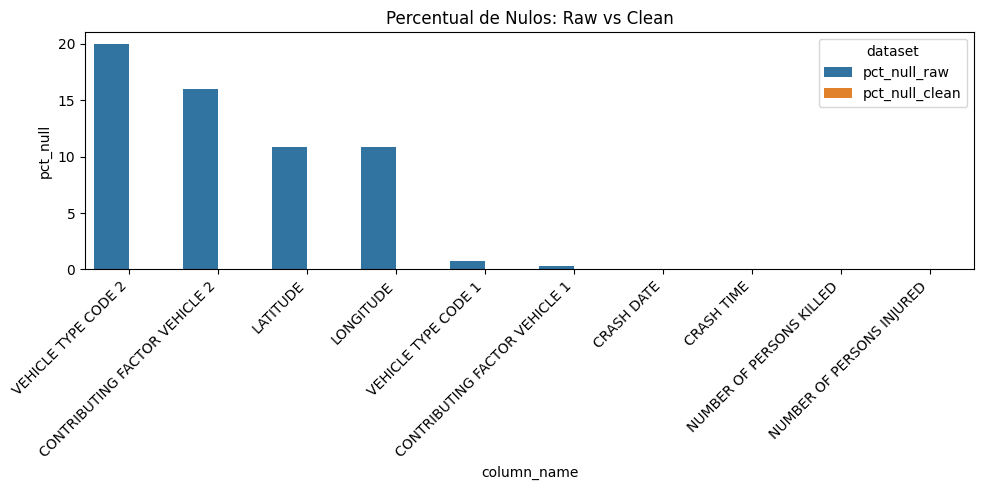

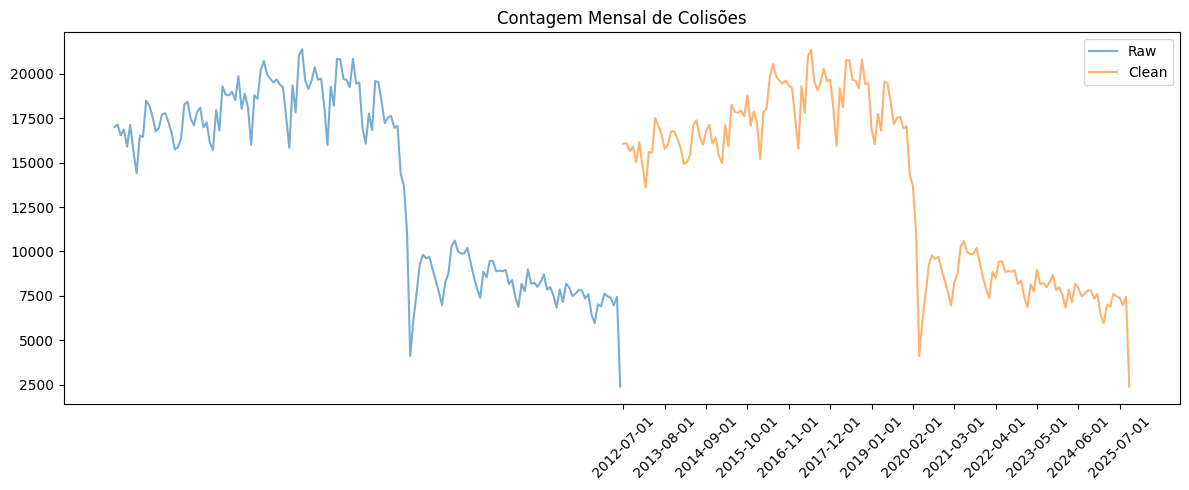

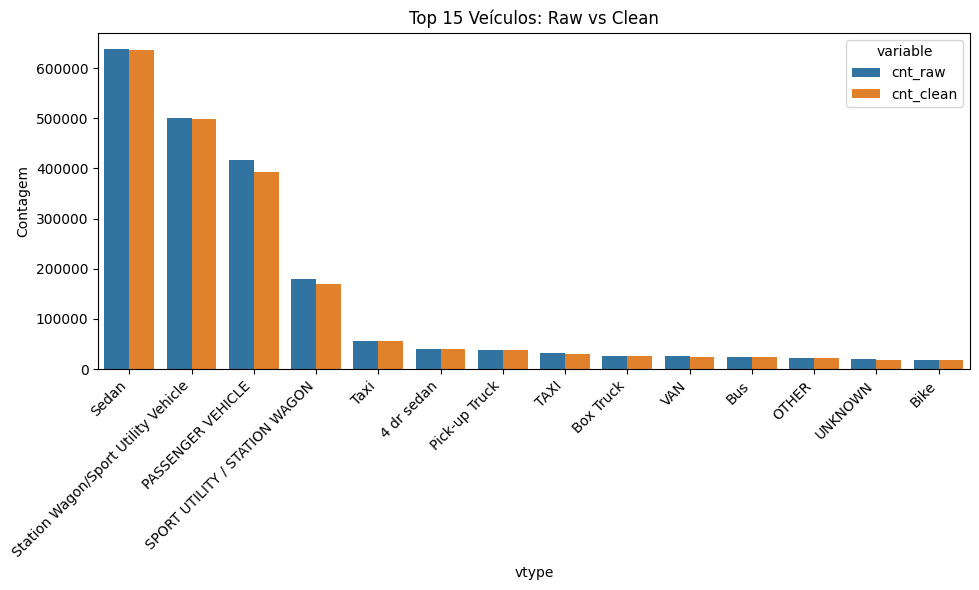

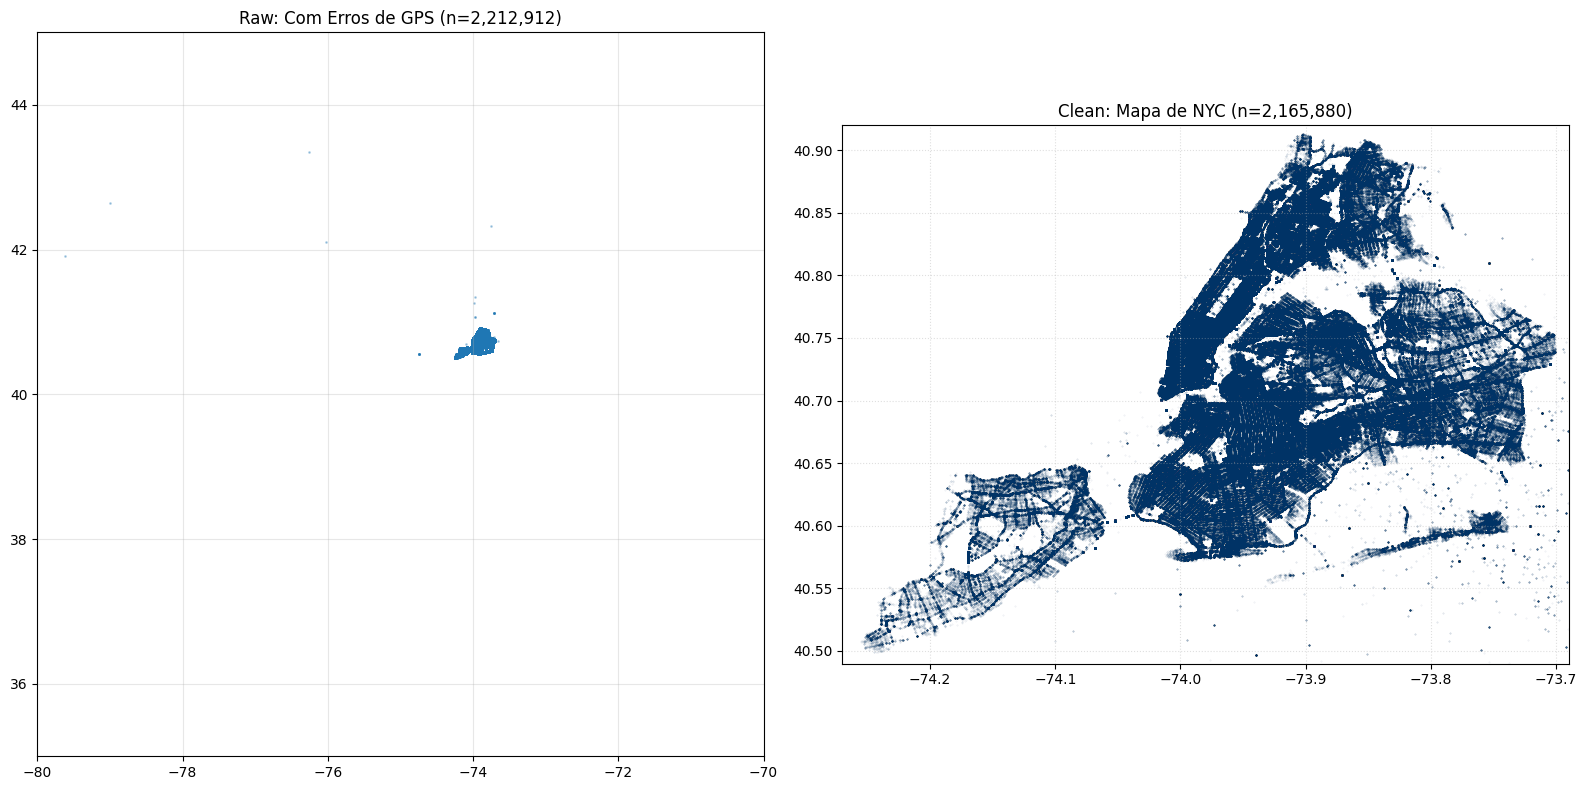

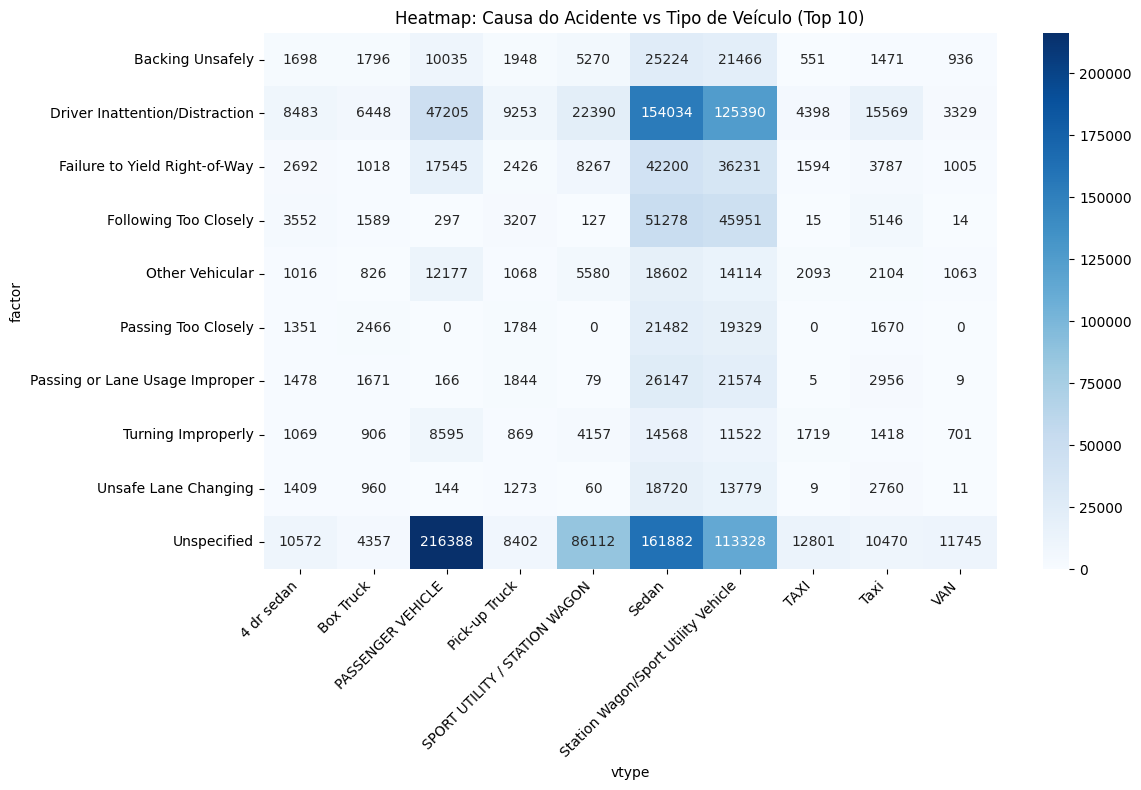

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

#1. Raw vs Clean
miss_compare = nulls_raw[['column_name','pct_null']].merge(
    nulls_clean[['column_name','pct_null']], on='column_name', suffixes=('_raw','_clean')
)

plt.figure(figsize=(10,5))
sns.barplot(data=miss_compare.melt(id_vars='column_name', value_name='pct_null', var_name='dataset'), 
            x='column_name', y='pct_null', hue='dataset')
plt.xticks(rotation=45, ha='right'); plt.title('Percentual de Nulos: Raw vs Clean'); plt.tight_layout(); plt.show()

# 2. Evolução Mensal 
plt.figure(figsize=(12,5))
plt.plot(monthly_raw['ym'], monthly_raw['cnt'], label='Raw', alpha=0.6)
plt.plot(monthly_clean['ym'], monthly_clean['cnt'], label='Clean', alpha=0.6)
plt.xticks(monthly_clean['ym'][::max(len(monthly_clean)//12, 1)], rotation=45)
plt.title('Contagem Mensal de Colisões'); plt.legend(); plt.tight_layout(); plt.show()

# 3. Top Tipos de Veículo 
veh_raw = veh_raw.rename(columns={'v': 'vtype', 'c': 'cnt'})
veh_clean = veh_clean.rename(columns={'v': 'vtype', 'c': 'cnt'})

veh_merge = veh_raw.merge(veh_clean, on='vtype', suffixes=('_raw','_clean'))
veh_sorted = veh_merge.sort_values('cnt_clean', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=veh_sorted.melt(id_vars='vtype', value_vars=['cnt_raw','cnt_clean']), 
            x='vtype', y='value', hue='variable')
plt.xticks(rotation=45, ha='right'); plt.title('Top 15 Veículos: Raw vs Clean'); plt.ylabel('Contagem'); plt.tight_layout(); plt.show()

# 4. Coordenadas Geográficas 
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].scatter(df_raw['LONGITUDE'], df_raw['LATITUDE'], s=1, alpha=0.3)
axes[0].set_title(f'Raw: Com Erros de GPS (n={len(df_raw):,})')
axes[0].set_xlim(-80, -70) # Zoom out
axes[0].set_ylim(35, 45)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_cleaned['LONGITUDE'], df_cleaned['LATITUDE'], 
                s=0.1, alpha=0.1, color='#003366') 
axes[1].set_title(f'Clean: Mapa de NYC (n={len(df_cleaned):,})')

axes[1].set_xlim([-74.27, -73.69]) 
axes[1].set_ylim([40.49, 40.92])
axes[1].set_aspect('equal') 
axes[1].grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()
# 5. Heatmap (Fatores x Tipos)
df_heat = conn.execute("""
    SELECT "CONTRIBUTING FACTOR VEHICLE 1" AS factor, "VEHICLE TYPE CODE 1" AS vtype
    FROM crashes_clean
    WHERE factor IS NOT NULL AND vtype IS NOT NULL AND TRIM(factor)<>'' AND TRIM(vtype)<>''
""").df()

top_factors = df_heat['factor'].value_counts().head(10).index
top_vtypes = df_heat['vtype'].value_counts().head(10).index
pivot = pd.crosstab(df_heat[df_heat['factor'].isin(top_factors)]['factor'], 
                    df_heat[df_heat['vtype'].isin(top_vtypes)]['vtype'])

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='Blues', annot=True, fmt='d')
plt.title('Heatmap: Causa do Acidente vs Tipo de Veículo (Top 10)'); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# Parte 3 

In [28]:
print(f"Estrutura do Dataset Limpo: {df_cleaned.shape}")

# Lista colunas e seus tipos de dados
print("\nTipos de dados:")
print(df_cleaned.dtypes)

# Visualização das primeiras linhas
df_cleaned.head()

Estrutura do Dataset Limpo: (2165880, 29)

Tipos de dados:
CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                          string[python]
ZIP CODE                         string[python]
LATITUDE                                float64
LONGITUDE                               float64
ON STREET NAME                   string[python]
CROSS STREET NAME                string[python]
OFF STREET NAME                  string[python]
NUMBER OF PERSONS INJURED                 Int64
NUMBER OF PERSONS KILLED                  Int64
NUMBER OF PEDESTRIANS INJURED             Int64
NUMBER OF PEDESTRIANS KILLED              Int64
NUMBER OF CYCLIST INJURED                 Int64
NUMBER OF CYCLIST KILLED                  Int64
NUMBER OF MOTORIST INJURED                Int64
NUMBER OF MOTORIST KILLED                 Int64
CONTRIBUTING FACTOR VEHICLE 1    string[python]
CONTRIBUTING FACTOR VEHICLE 2    string[python]
CONTRIBUTING FACTOR VEHICLE 3

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DAY_OF_WEEK
0,2021-09-11,02:39:00,BRONX,N/A,33.967438,-61.553289,WHITESTONE EXPRESSWAY,20 AVENUE,N/A,2,...,Unspecified,Unspecified,Unspecified,4455765,Sedan,Sedan,N/A,N/A,N/A,Saturday
1,2022-03-26,11:45:00,MANHATTAN,N/A,40.757162,-73.955305,QUEENSBORO BRIDGE UPPER,N/A,N/A,1,...,Unspecified,Unspecified,Unspecified,4513547,Sedan,N/A,N/A,N/A,N/A,Saturday
2,2023-11-01,01:29:00,BROOKLYN,11230.0,40.621790,-73.970024,OCEAN PARKWAY,AVENUE K,N/A,1,...,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan,N/A,N/A,Wednesday
3,2022-06-29,06:55:00,BRONX,N/A,40.808303,-73.797393,THROGS NECK BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4541903,Sedan,Pick-up Truck,N/A,N/A,N/A,Wednesday
4,2022-09-21,13:21:00,BROOKLYN,N/A,40.405489,-73.450636,BROOKLYN BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4566131,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Wednesday


Reestruturação Necessária

#### Análise de Variáveis Compostas
O dataset atual possui variáveis que violam princípios tidy:
1. **Múltiplos veículos** (VEHICLE TYPE CODE 1-5): formato wide
2. **Múltiplos fatores** (CONTRIBUTING FACTOR 1-5): formato wide  
3. **Múltiplas contagens** (PERSONS/PEDESTRIANS/CYCLISTS/MOTORISTS INJURED/KILLED): podem ser normalizadas

Vamos criar diferentes visões tidy para diferentes análises:

In [29]:
print("Transformação 1: Veículos (Wide -> Long)")

# Seleção de colunas
base_cols = ['COLLISION_ID', 'CRASH DATE', 'CRASH TIME', 'DAY_OF_WEEK', 'BOROUGH', 'LATITUDE', 'LONGITUDE']
vehicle_type_cols = [c for c in df_cleaned.columns if 'VEHICLE TYPE CODE' in c]

# Melt: Transforma colunas de tipo de veículo em linhas
df_vehicles_long = df_cleaned.melt(
    id_vars=base_cols,
    value_vars=vehicle_type_cols,
    var_name='vehicle_number',
    value_name='vehicle_type'
)

# Extração do índice do veículo e limpeza de nulos
df_vehicles_long['vehicle_number'] = df_vehicles_long['vehicle_number'].str.extract(r'(\d+)').astype(int)

df_vehicles_long = df_vehicles_long[
    df_vehicles_long['vehicle_type'].notna() & 
    (df_vehicles_long['vehicle_type'] != 'N/A')
].sort_values(['COLLISION_ID', 'vehicle_number']).reset_index(drop=True)

print(f"Dataset Tidy (Long): {df_vehicles_long.shape}")
print(f"Colisões únicas: {df_vehicles_long['COLLISION_ID'].nunique():,}")
print(f"Total de veículos envolvidos: {len(df_vehicles_long):,}")

df_vehicles_long.head()

Transformação 1: Veículos (Wide -> Long)
Dataset Tidy (Long): (4072286, 9)
Colisões únicas: 2,149,960
Total de veículos envolvidos: 4,072,286


,COLLISION_ID,CRASH DATE,CRASH TIME,DAY_OF_WEEK,BOROUGH,LATITUDE,LONGITUDE,vehicle_number,vehicle_type
0,22,2012-07-01,10:40:00,Sunday,MANHATTAN,40.720854,-74.003929,1,SPORT UTILITY / STATION WAGON
1,22,2012-07-01,10:40:00,Sunday,MANHATTAN,40.720854,-74.003929,2,VAN
2,23,2012-07-01,12:18:00,Sunday,MANHATTAN,40.704799,-74.016685,1,TAXI
3,23,2012-07-01,12:18:00,Sunday,MANHATTAN,40.704799,-74.016685,2,TAXI
4,24,2012-07-01,15:00:00,Sunday,MANHATTAN,40.704212,-74.008800,1,BUS


In [30]:
print("Transformação 2: Fatores Contribuintes (Wide -> Long)")

base_cols = ['COLLISION_ID', 'CRASH DATE', 'CRASH TIME', 'DAY_OF_WEEK', 'BOROUGH', 'LATITUDE', 'LONGITUDE']
factor_cols = [c for c in df_cleaned.columns if 'CONTRIBUTING FACTOR' in c]

df_factors_long = df_cleaned.melt(
    id_vars=base_cols,
    value_vars=factor_cols,
    var_name='contributing_number',
    value_name='contributing_factor'
)

# Extração do índice do veículo e limpeza
df_factors_long['contributing_number'] = df_factors_long['contributing_number'].str.extract(r'(\d+)').astype(int)

# Filtra nulos, 'N/A' e strings vazias
df_factors_long = df_factors_long[
    df_factors_long['contributing_factor'].notna() & 
    (df_factors_long['contributing_factor'] != 'Unspecified') & 
    (df_factors_long['contributing_factor'].str.strip() != '')
].sort_values(['COLLISION_ID', 'contributing_number']).reset_index(drop=True)

print(f"Dataset Tidy (Long): {df_factors_long.shape}")
print(f"Colisões únicas: {df_factors_long['COLLISION_ID'].nunique():,}")
print(f"Fatores únicos identificados: {df_factors_long['contributing_factor'].nunique()}")

df_factors_long.head()

Transformação 2: Fatores Contribuintes (Wide -> Long)
Dataset Tidy (Long): (1737686, 9)
Colisões únicas: 1,436,990
Fatores únicos identificados: 60
Dataset Tidy (Long): (1737686, 9)
Colisões únicas: 1,436,990
Fatores únicos identificados: 60


,COLLISION_ID,CRASH DATE,CRASH TIME,DAY_OF_WEEK,BOROUGH,LATITUDE,LONGITUDE,contributing_number,contributing_factor
0,24,2012-07-01,15:00:00,Sunday,MANHATTAN,40.704212,-74.008800,1,Oversized Vehicle
1,25,2012-07-01,18:00:00,Sunday,MANHATTAN,40.713692,-74.013754,1,Driver Inattention/Distraction
2,26,2012-07-01,19:30:00,Sunday,MANHATTAN,40.719058,-74.012442,1,Driver Inattention/Distraction
3,27,2012-07-01,20:00:00,Sunday,MANHATTAN,40.707978,-74.008004,1,Backing Unsafely
4,28,2012-07-01,22:45:00,Sunday,MANHATTAN,40.725797,-73.997612,1,Driver Inattention/Distraction


In [31]:
print("Transformação 3: Vítimas (Wide -> Long)")

base_cols = ['COLLISION_ID', 'CRASH DATE', 'CRASH TIME', 'DAY_OF_WEEK', 'BOROUGH', 'LATITUDE', 'LONGITUDE']
casualty_cols = [c for c in df_cleaned.columns if 'NUMBER OF' in c]

df_casualties_long = df_cleaned.melt(
    id_vars=base_cols,
    value_vars=casualty_cols,
    var_name='description',
    value_name='count'
)

# Mantém apenas registros onde houve vítimas (count > 0)
df_casualties_long = df_casualties_long[df_casualties_long['count'] > 0].copy()

# Extrai Tipo e Gravidade usando Regex na descrição da coluna
# Ex: "NUMBER OF PEDESTRIANS INJURED" -> Grupo 1: PEDESTRIANS, Grupo 2: INJURED
pattern = r'NUMBER OF (.+) (INJURED|KILLED)'
extracted = df_casualties_long['description'].str.extract(pattern)
df_casualties_long['victim_type'] = extracted[0]
df_casualties_long['severity'] = extracted[1]

# Remove coluna auxiliar
df_casualties_long = df_casualties_long.drop(columns=['description'])

print(f"Dataset Tidy (Long): {df_casualties_long.shape}")
print(f"Total de vítimas contabilizadas: {df_casualties_long['count'].sum():,.0f}")

print("\nDistribuição por tipo:")
print(df_casualties_long.groupby(['victim_type', 'severity'])['count'].sum().sort_values(ascending=False))

df_casualties_long.head()

Transformação 3: Vítimas (Wide -> Long)
Dataset Tidy (Long): (1054146, 10)
Total de vítimas contabilizadas: 1,422,111

Distribuição por tipo:
victim_type  severity
PERSONS      INJURED     712730
MOTORIST     INJURED     507974
PEDESTRIANS  INJURED     130649
CYCLIST      INJURED      63932
PERSONS      KILLED        3446
PEDESTRIANS  KILLED        1709
MOTORIST     KILLED        1395
CYCLIST      KILLED         276
Name: count, dtype: Int64


,COLLISION_ID,CRASH DATE,CRASH TIME,DAY_OF_WEEK,BOROUGH,LATITUDE,LONGITUDE,count,victim_type,severity
0,4455765,2021-09-11,02:39:00,Saturday,BRONX,33.967438,-61.553289,2,PERSONS,INJURED
1,4513547,2022-03-26,11:45:00,Saturday,MANHATTAN,40.757162,-73.955305,1,PERSONS,INJURED
2,4675373,2023-11-01,01:29:00,Wednesday,BROOKLYN,40.621790,-73.970024,1,PERSONS,INJURED
12,4486660,2021-12-14,08:17:00,Tuesday,BRONX,40.868160,-73.831480,2,PERSONS,INJURED
19,4486635,2021-12-14,23:10:00,Tuesday,QUEENS,40.666840,-73.789410,2,PERSONS,INJURED


In [32]:
print("Transformação 4: Tabela Principal Tidy")

# Seleção de colunas atômicas (variáveis únicas por colisão)
cols_main = [
    'COLLISION_ID', 'CRASH DATE', 'CRASH TIME', 'DAY_OF_WEEK',
    'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
    'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'
]

df_tidy_main = df_cleaned[cols_main].copy()

print(f"Shape Tabela Principal: {df_tidy_main.shape}")
print("\nTipos de dados:")
print(df_tidy_main.dtypes)

# Resumo estatístico
df_tidy_main.describe()

Transformação 4: Tabela Principal Tidy
Shape Tabela Principal: (2165880, 19)

Tipos de dados:
COLLISION_ID                              int64
CRASH DATE                       datetime64[ns]
CRASH TIME                               object
DAY_OF_WEEK                      string[python]
BOROUGH                          string[python]
ZIP CODE                         string[python]
LATITUDE                                float64
LONGITUDE                               float64
ON STREET NAME                   string[python]
CROSS STREET NAME                string[python]
OFF STREET NAME                  string[python]
NUMBER OF PERSONS INJURED                 Int64
NUMBER OF PERSONS KILLED                  Int64
NUMBER OF PEDESTRIANS INJURED             Int64
NUMBER OF PEDESTRIANS KILLED              Int64
NUMBER OF CYCLIST INJURED                 Int64
NUMBER OF CYCLIST KILLED                  Int64
NUMBER OF MOTORIST INJURED                Int64
NUMBER OF MOTORIST KILLED                 

,COLLISION_ID,CRASH DATE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
count,2.165880e+06,2165880,2.165880e+06,2.165880e+06,2165880.0,2165880.0,2165880.0,2165880.0,2165880.0,2165880.0,2165880.0,2165880.0
mean,3.274182e+06,2018-01-29 04:35:47.753337344,4.056070e+01,-7.363684e+01,0.329072,0.001591,0.060321,0.000789,0.029518,0.000127,0.234535,0.000644
min,2.200000e+01,2012-07-01 00:00:00,0.000000e+00,-2.013600e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,3.209308e+06,2015-04-24 00:00:00,4.066549e+01,-7.397347e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.763684e+06,2017-09-28 00:00:00,4.071858e+01,-7.392373e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.306786e+06,2020-03-27 00:00:00,4.076870e+01,-7.385965e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4.849667e+06,2025-10-11 00:00:00,4.334444e+01,0.000000e+00,43.0,8.0,27.0,6.0,4.0,2.0,43.0,5.0
std,1.512498e+06,NaN,2.330452e+00,4.404247e+00,0.714548,0.042153,0.25147,0.028713,0.171494,0.011329,0.675269,0.027785


In [33]:
# Validação da estrutura final
print("Resumo dos Datasets Tidy")
for nome, df in [('Principal', df_tidy_main), ('Veículos', df_vehicles_long), 
                 ('Fatores', df_factors_long), ('Vítimas', df_casualties_long)]:
    print(f"\n[{nome}] Shape: {df.shape} | Duplicatas: {df.duplicated().sum()}")
    print(df.dtypes)

Resumo dos Datasets Tidy

[Principal] Shape: (2165880, 19) | Duplicatas: 0
COLLISION_ID                              int64
CRASH DATE                       datetime64[ns]
CRASH TIME                               object
DAY_OF_WEEK                      string[python]
BOROUGH                          string[python]
ZIP CODE                         string[python]
LATITUDE                                float64
LONGITUDE                               float64
ON STREET NAME                   string[python]
CROSS STREET NAME                string[python]
OFF STREET NAME                  string[python]
NUMBER OF PERSONS INJURED                 Int64
NUMBER OF PERSONS KILLED                  Int64
NUMBER OF PEDESTRIANS INJURED             Int64
NUMBER OF PEDESTRIANS KILLED              Int64
NUMBER OF CYCLIST INJURED                 Int64
NUMBER OF CYCLIST KILLED                  Int64
NUMBER OF MOTORIST INJURED                Int64
NUMBER OF MOTORIST KILLED                 Int64
dtype: object

In [34]:
# Registro dos DataFrames no DuckDB
conn.register('collisions_tidy', df_tidy_main)
conn.register('vehicles_tidy', df_vehicles_long)
conn.register('factors_tidy', df_factors_long)
conn.register('casualties_tidy', df_casualties_long)

# Validação dos registros (Contagens e Somas)
queries = {
    'collisions_tidy (rows)': "SELECT COUNT(*) FROM collisions_tidy",
    'vehicles_tidy (rows)': "SELECT COUNT(*) FROM vehicles_tidy",
    'factors_tidy (rows)': "SELECT COUNT(*) FROM factors_tidy",
    'casualties_tidy (total victims)': "SELECT SUM(count) FROM casualties_tidy"
}

print("Status do Registro no DuckDB")
for label, q in queries.items():
    res = conn.execute(q).fetchone()[0]
    print(f"{label}: {res:,.0f}")

Status do Registro no DuckDB
collisions_tidy (rows): 2,165,880
collisions_tidy (rows): 2,165,880
vehicles_tidy (rows): 4,072,286
factors_tidy (rows): 1,737,686
casualties_tidy (total victims): 1,422,111
vehicles_tidy (rows): 4,072,286
factors_tidy (rows): 1,737,686
casualties_tidy (total victims): 1,422,111


In [35]:
output_dir = '../processed_data'
os.makedirs(output_dir, exist_ok=True)

datasets = {
    'collisions_tidy.parquet': df_tidy_main,
    'vehicles_tidy.parquet': df_vehicles_long,
    'factors_tidy.parquet': df_factors_long,
    'casualties_tidy.parquet': df_casualties_long,
    'df_cleaned_full.parquet': df_cleaned
}

stats = []
for fname, df in datasets.items():
    fpath = os.path.join(output_dir, fname)
    df.to_parquet(fpath, compression='snappy', index=False)
    
    stats.append({
        'Arquivo': fname,
        'Linhas': len(df),
        'Colunas': df.shape[1],
        'MB': round(os.path.getsize(fpath) / (1024**2), 2)
    })

df_stats = pd.DataFrame(stats)
print(f"Exportação concluída! Tamanho total: {df_stats['MB'].sum():.2f} MB\n")
print(df_stats.to_string(index=False))

Exportação concluída! Tamanho total: 177.19 MB

                Arquivo  Linhas  Colunas    MB
collisions_tidy.parquet 2165880       19 44.53
  vehicles_tidy.parquet 4072286        9 45.73
   factors_tidy.parquet 1737686        9 22.18
casualties_tidy.parquet 1054146       10 14.14
df_cleaned_full.parquet 2165880       29 50.61


Consulta 1: Análise Temporal (Últimos 24 Meses)


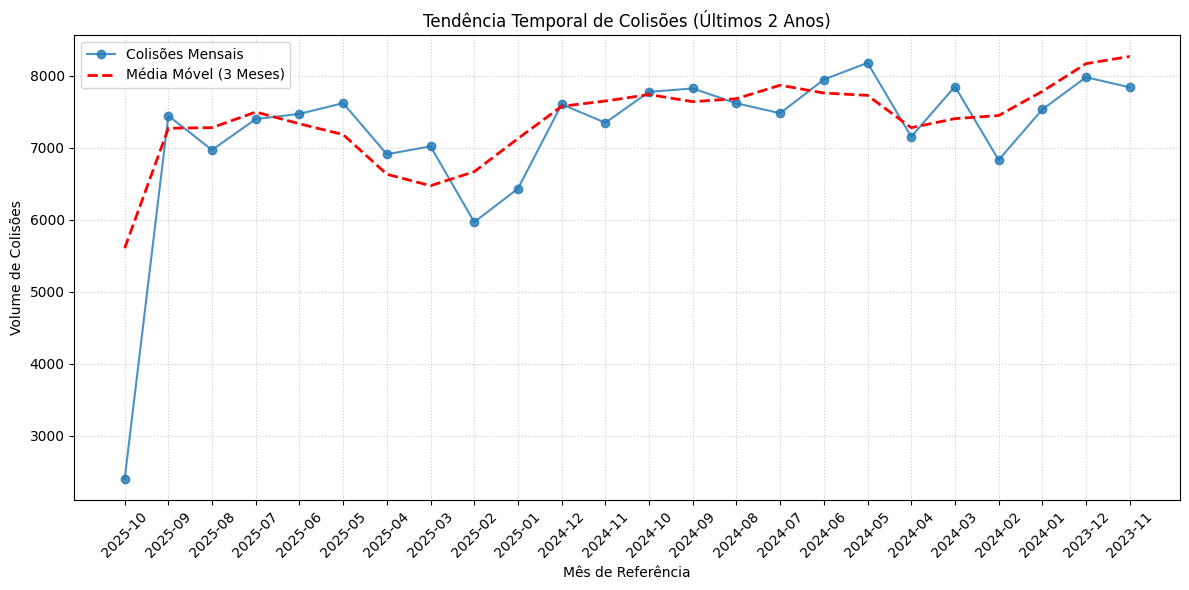

In [36]:
print("Consulta 1: Análise Temporal (Últimos 24 Meses)")

query_temporal = """
WITH monthly_data AS (
    SELECT 
        STRFTIME("CRASH DATE", '%Y-%m') AS year_month,
        COUNT(*) AS collisions,
        SUM("NUMBER OF PERSONS INJURED") AS injured,
        SUM("NUMBER OF PERSONS KILLED") AS killed
    FROM collisions_tidy
    WHERE "CRASH DATE" IS NOT NULL
    GROUP BY year_month
),
with_trends AS (
    SELECT 
        year_month,
        collisions,
        injured,
        killed,
        -- Média Móvel de 3 meses para suavizar tendências
        AVG(collisions) OVER (
            ORDER BY year_month 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) AS moving_avg_3m,
        -- Comparativo percentual com o mês anterior
        ROUND(100.0 * (collisions - LAG(collisions) OVER (ORDER BY year_month)) / 
              NULLIF(LAG(collisions) OVER (ORDER BY year_month), 0), 2) AS mom_growth_pct
    FROM monthly_data
)
SELECT * FROM with_trends ORDER BY year_month DESC LIMIT 24;
"""

df_temporal = conn.execute(query_temporal).df()

# Visualização Unificada: Evolução de Colisões
plt.figure(figsize=(12, 6))

# Dados reais
plt.plot(df_temporal['year_month'], df_temporal['collisions'], 
         marker='o', linestyle='-', color='#1f77b4', label='Colisões Mensais', alpha=0.8)

# Tendência (Média Móvel)
plt.plot(df_temporal['year_month'], df_temporal['moving_avg_3m'], 
         color='red', linestyle='--', linewidth=2, label='Média Móvel (3 Meses)')

plt.title('Tendência Temporal de Colisões (Últimos 2 Anos)')
plt.ylabel('Volume de Colisões')
plt.xlabel('Mês de Referência')
plt.xticks(rotation=45)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Consulta 2: Perfil de Vítimas por bairro
      borough  total_collisions  ped_injured  cyc_injured  mot_injured  avg_severity
     BROOKLYN            646019      43567.0      24561.0     160595.0         0.360
       QUEENS            626923      31702.0      12430.0     163367.0         0.335
    MANHATTAN            446316      28706.0      19155.0      60977.0         0.248
        BRONX            331369      21948.0       6786.0      91941.0         0.369
STATEN ISLAND            115253       4726.0       1000.0      31094.0         0.321


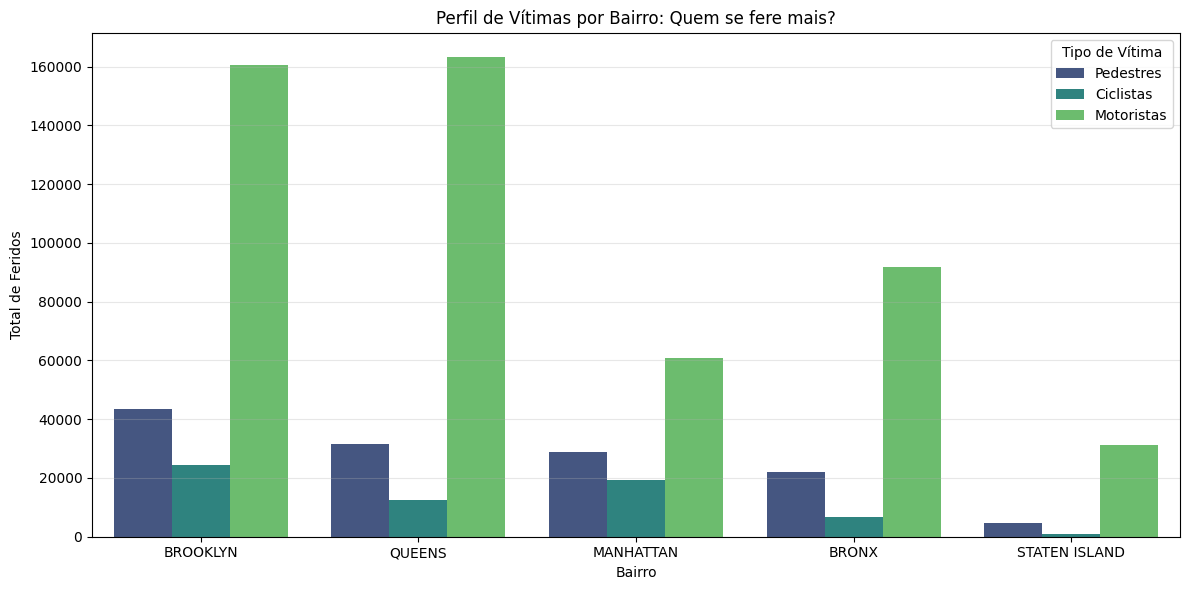

In [37]:
print("Consulta 2: Perfil de Vítimas por bairro")

query_borough = """
SELECT 
    COALESCE(BOROUGH, 'Unknown') AS borough,
    COUNT(*) AS total_collisions,
    SUM("NUMBER OF PEDESTRIANS INJURED") AS ped_injured,
    SUM("NUMBER OF CYCLIST INJURED") AS cyc_injured,
    SUM("NUMBER OF MOTORIST INJURED") AS mot_injured,
    -- Taxa de severidade (feridos por colisão)
    ROUND(AVG("NUMBER OF PERSONS INJURED"), 3) AS avg_severity
FROM collisions_tidy
GROUP BY borough
ORDER BY total_collisions DESC;
"""

df_borough = conn.execute(query_borough).df()

print(df_borough.to_string(index=False))

# Prepara dados para o gráfico (Melt para formato longo compatível com Seaborn)
df_melt = df_borough.melt(
    id_vars='borough', 
    value_vars=['ped_injured', 'cyc_injured', 'mot_injured'],
    var_name='Tipo Vítima', 
    value_name='Qtd Feridos'
)

df_melt['Tipo Vítima'] = df_melt['Tipo Vítima'].replace({
    'ped_injured': 'Pedestres', 
    'cyc_injured': 'Ciclistas', 
    'mot_injured': 'Motoristas'
})

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='borough', y='Qtd Feridos', hue='Tipo Vítima', palette='viridis')

plt.title('Perfil de Vítimas por Bairro: Quem se fere mais?')
plt.ylabel('Total de Feridos')
plt.xlabel('Bairro')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Tipo de Vítima')
plt.tight_layout()
plt.show()

Consulta 3: Matriz de Risco (Frequência vs Severidade)
Fatores analisados: 54
                        factor  frequency  severity_index  total_killed
Driver Inattention/Distraction     468505            0.43         467.0
 Failure to Yield Right-of-Way     142118            0.57         316.0
         Following Too Closely     132741            0.47          27.0
              Backing Unsafely      84835            0.14          47.0
               Other Vehicular      79591            0.42          51.0
Passing or Lane Usage Improper      70876            0.27          54.0
           Passing Too Closely      61869            0.11           3.0
            Turning Improperly      57946            0.26          27.0
               Fatigued/Drowsy      48466            0.29           2.0
          Unsafe Lane Changing      48026            0.27          19.0
Fatores analisados: 54
                        factor  frequency  severity_index  total_killed
Driver Inattention/Distraction     

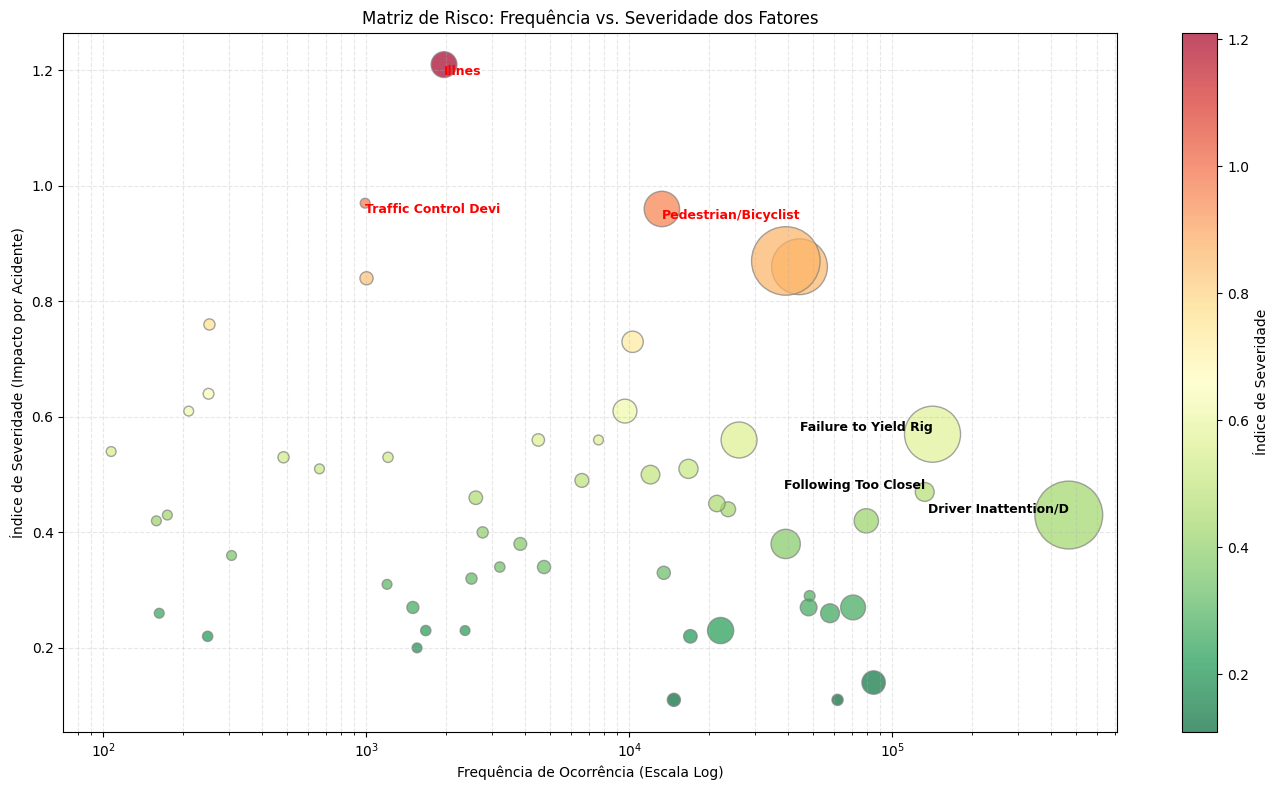

In [38]:
print("Consulta 3: Matriz de Risco (Frequência vs Severidade)")

# Query simplificada para métricas de risco
query_factors = """
SELECT 
    contributing_factor AS factor,
    COUNT(DISTINCT c.COLLISION_ID) AS frequency,
    -- Índice de Severidade: (Feridos + 10x Mortos) / Total Colisões
    ROUND(SUM(c."NUMBER OF PERSONS INJURED" + (c."NUMBER OF PERSONS KILLED" * 10)) * 1.0 / 
          COUNT(DISTINCT c.COLLISION_ID), 2) AS severity_index,
    SUM(c."NUMBER OF PERSONS KILLED") AS total_killed
FROM factors_tidy f
JOIN collisions_tidy c ON f.COLLISION_ID = c.COLLISION_ID
WHERE f.contributing_factor != 'Unspecified'
GROUP BY factor
HAVING frequency > 100 -- Filtro de relevância estatística
ORDER BY frequency DESC;
"""

df_risk = conn.execute(query_factors).df()

print(f"Fatores analisados: {len(df_risk)}")
print(df_risk.head(10).to_string(index=False))

plt.figure(figsize=(14, 8))

# X: Frequência (Log), Y: Severidade, Cor/Tamanho: Total de Mortos
scatter = plt.scatter(
    df_risk['frequency'], 
    df_risk['severity_index'], 
    s=df_risk['total_killed'] * 5 + 50, #
    c=df_risk['severity_index'],        
    cmap='RdYlGn_r',                  
    alpha=0.7, 
    edgecolors='grey'
)

plt.xscale('log')
plt.title('Matriz de Risco: Frequência vs. Severidade dos Fatores')
plt.xlabel('Frequência de Ocorrência (Escala Log)')
plt.ylabel('Índice de Severidade (Impacto por Acidente)')
plt.grid(True, which="both", ls="--", alpha=0.3)


for _, row in df_risk.nlargest(3, 'frequency').iterrows():
    plt.text(row['frequency'], row['severity_index'], row['factor'][:20], 
             fontsize=9, ha='right', va='bottom', fontweight='bold')


for _, row in df_risk.nlargest(3, 'severity_index').iterrows():
    plt.text(row['frequency'], row['severity_index'], row['factor'][:20], 
             fontsize=9, ha='left', va='top', color='red', fontweight='bold')

plt.colorbar(scatter, label='Índice de Severidade')
plt.tight_layout()
plt.show()

Consulta 4: Padrões Temporais (Heatmap Semanal)


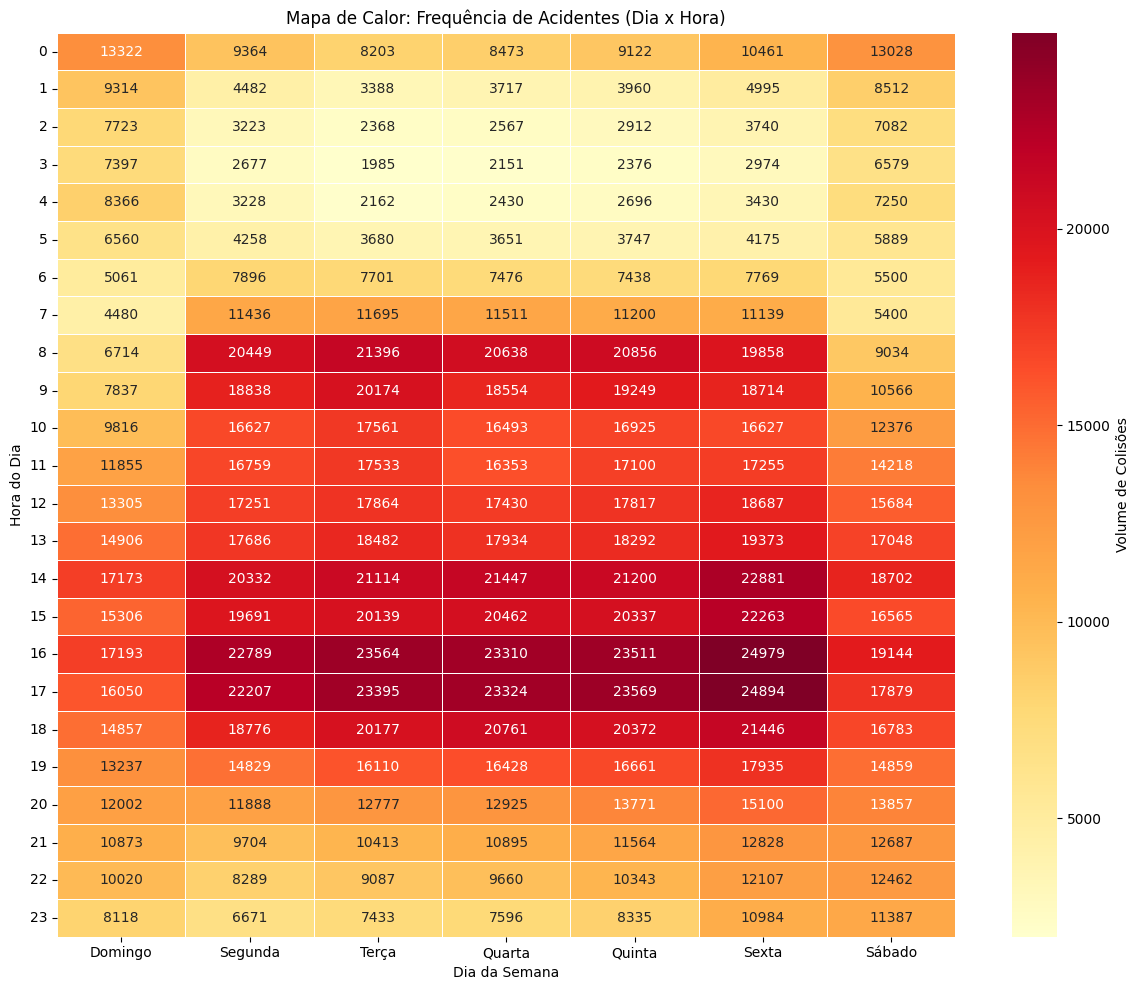

In [39]:
print("Consulta 4: Padrões Temporais (Heatmap Semanal)")

query_time = """
SELECT 
    "DAY_OF_WEEK" AS day_of_week,
    EXTRACT(HOUR FROM "CRASH TIME") AS hour,
    COUNT(*) AS collisions
FROM collisions_tidy
WHERE "CRASH TIME" IS NOT NULL
GROUP BY day_of_week, hour;
"""

df_time = conn.execute(query_time).df()

# Tradução e Ordenação
day_map = {
    'Sunday': 'Domingo', 'Monday': 'Segunda', 'Tuesday': 'Terça',
    'Wednesday': 'Quarta', 'Thursday': 'Quinta', 'Friday': 'Sexta', 'Saturday': 'Sábado'
}
day_order = ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado']

# Cria a matriz (Pivot Table): Linhas = Horas, Colunas = Dias
pivot_table = df_time.pivot_table(
    index='hour', 
    columns='day_of_week', 
    values='collisions', 
    aggfunc='sum'
).rename(columns=day_map).reindex(columns=day_order)

plt.figure(figsize=(12, 10))

sns.heatmap(
    pivot_table, 
    cmap='YlOrRd',      
    annot=True,         
    fmt='.0f',         
    linewidths=.5,     
    cbar_kws={'label': 'Volume de Colisões'}
)

plt.title('Mapa de Calor: Frequência de Acidentes (Dia x Hora)')
plt.ylabel('Hora do Dia')
plt.xlabel('Dia da Semana')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Consulta 6: Mapa Simples de Hotspots
   lat     lon       borough  collisions
40.607 -74.043 STATEN ISLAND        2197
40.795 -73.924     MANHATTAN        2020
40.628 -73.888        QUEENS        1969
40.761 -73.964     MANHATTAN        1565
40.696 -73.985      BROOKLYN        1476


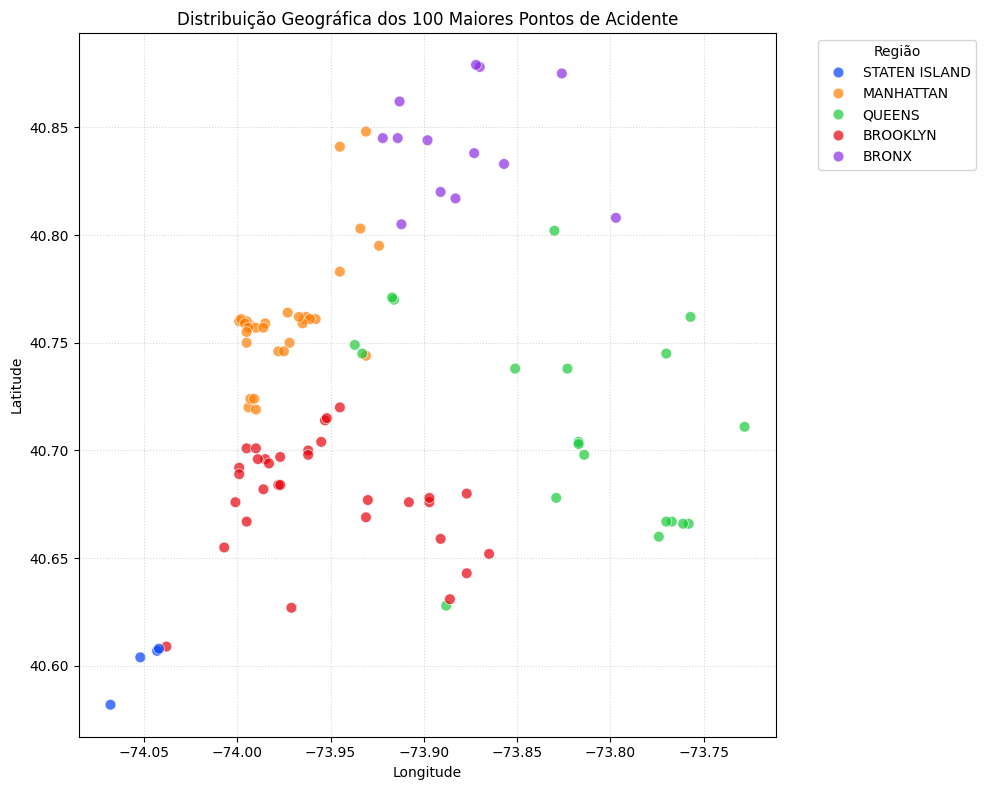

In [40]:
print("Consulta 5: Mapa Simples de Hotspots")

query_hotspots = """
SELECT 
    ROUND(LATITUDE, 3) AS lat,
    ROUND(LONGITUDE, 3) AS lon,
    COALESCE(BOROUGH, 'Desconhecido') AS borough,
    COUNT(*) AS collisions
FROM collisions_tidy
WHERE LATITUDE BETWEEN 40.49 AND 40.92 
  AND LONGITUDE BETWEEN -74.26 AND -73.69
GROUP BY lat, lon, borough
HAVING collisions >= 10
ORDER BY collisions DESC
LIMIT 100;
"""

df_hotspots = conn.execute(query_hotspots).df()
print(df_hotspots.head().to_string(index=False))

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_hotspots, 
    x='lon', 
    y='lat', 
    hue='borough',  # Colore por região para facilitar a leitura
    palette='bright',
    s=60,           # Tamanho fixo dos pontos
    alpha=0.7       # Leve transparência
)

plt.title('Distribuição Geográfica dos 100 Maiores Pontos de Acidente')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print("Derivação de Variáveis Auxiliares")

# 1. Padronização de Tempo
# Garante que CRASH TIME é string para extração segura, depois converte para data
time_objs = pd.to_datetime(df_tidy_main['CRASH TIME'].astype(str), format='%H:%M:%S', errors='coerce')
df_tidy_main['hour'] = time_objs.dt.hour.fillna(0).astype(int) # Preenche nulos com 0 por segurança

# 2. Variáveis de Calendário
df_tidy_main['day_of_week'] = df_tidy_main['DAY_OF_WEEK']
df_tidy_main['is_weekend'] = df_tidy_main['day_of_week'].isin(['Saturday', 'Sunday'])

# 3. Classificação de Período (Vetorizada com np.select)
cond_night = df_tidy_main['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5])
cond_peak = df_tidy_main['hour'].isin([7, 8, 9, 17, 18, 19])

df_tidy_main['hour_period'] = np.select(
    [cond_night, cond_peak], 
    ['Noite/Madrugada', 'Pico'], 
    default='Intermediário'
)

# 4. Métricas de Severidade
# Colunas totais diretamente para evitar dupla contagem.
df_tidy_main['fatalities_total'] = df_tidy_main['NUMBER OF PERSONS KILLED'].fillna(0)
df_tidy_main['injuries_total'] = df_tidy_main['NUMBER OF PERSONS INJURED'].fillna(0)

# Índice de Severidade (Peso 5 para mortes)
df_tidy_main['severity_index'] = df_tidy_main['injuries_total'] + (df_tidy_main['fatalities_total'] * 5)

cols_view = ['day_of_week', 'is_weekend', 'hour', 'hour_period', 'fatalities_total', 'severity_index']
print(df_tidy_main[cols_view].head())

Derivação de Variáveis Auxiliares
  day_of_week  is_weekend  hour      hour_period  fatalities_total  \
0    Saturday        True     2  Noite/Madrugada                 0   
1    Saturday        True    11    Intermediário                 0   
2   Wednesday       False     1  Noite/Madrugada                 0   
3   Wednesday       False     6    Intermediário                 0   
4   Wednesday       False    13    Intermediário                 0   

   severity_index  
0               2  
1               1  
2               1  
3               0  
4               0  
  day_of_week  is_weekend  hour      hour_period  fatalities_total  \
0    Saturday        True     2  Noite/Madrugada                 0   
1    Saturday        True    11    Intermediário                 0   
2   Wednesday       False     1  Noite/Madrugada                 0   
3   Wednesday       False     6    Intermediário                 0   
4   Wednesday       False    13    Intermediário                 0   

   s

Análise Univariada


/tmp/ipykernel_37562/1481304637.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_tidy_main, x='hour_period', ax=ax[1], palette='Set2')
/tmp/ipykernel_37562/1481304637.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_tidy_main, x='day_of_week', order=order_days, ax=ax[2], palette='viridis')
/tmp/ipykernel_37562/1481304637.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_tidy_main, x='day_of_week', order=order_days, ax=ax[2], palette='viridis')


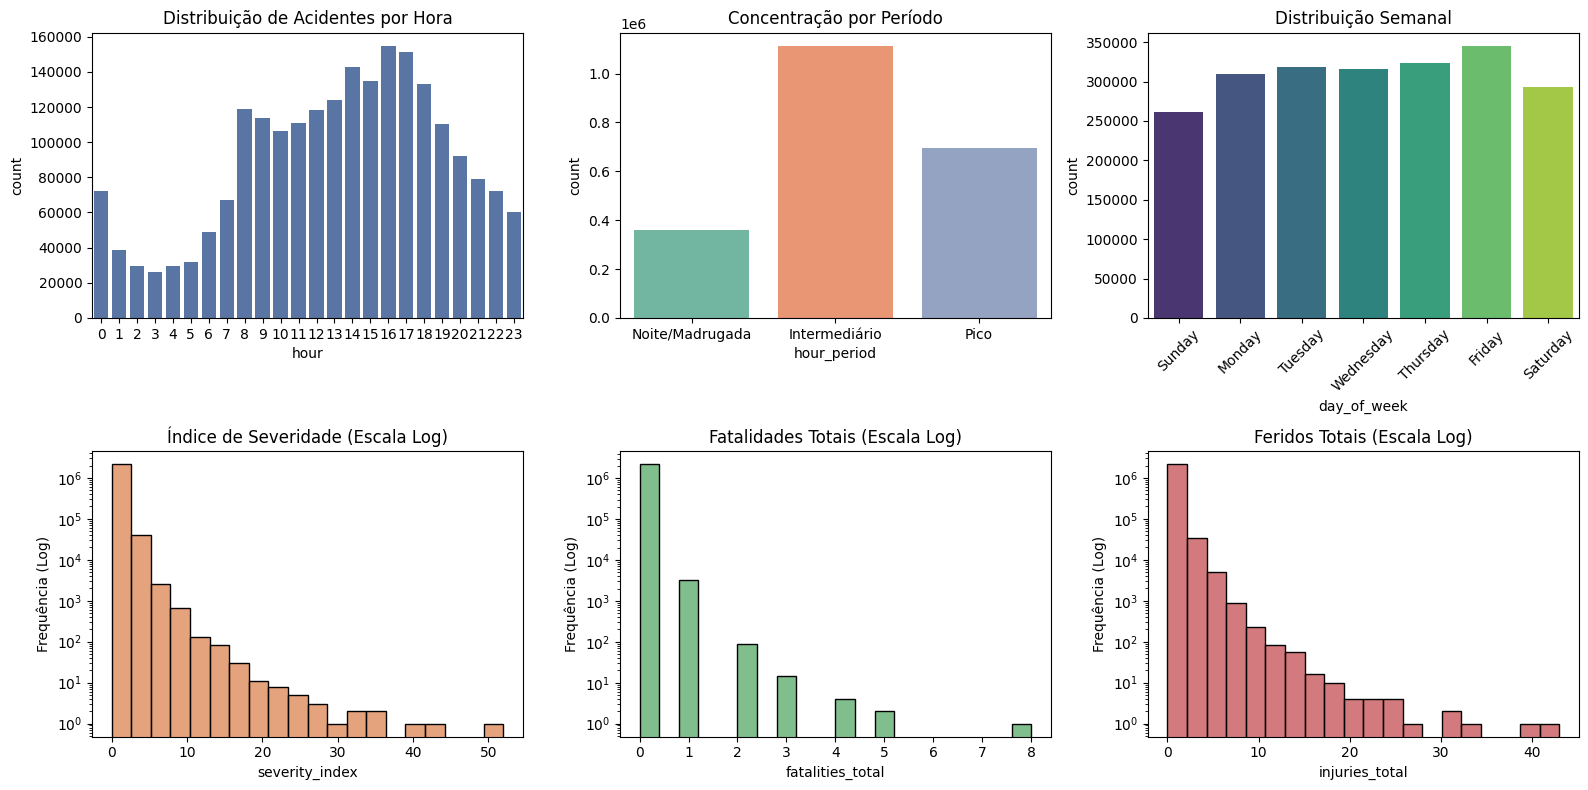


Resumo Estatístico e Distribuição:
                   mean    std   max    skew  kurtosis  outliers_count
fatalities_total  0.002  0.042   8.0  32.631  1771.733            3302
injuries_total    0.329  0.715  43.0    4.08    47.004          526901
severity_index    0.337  0.748  52.0   4.584    63.873          529389


In [42]:
print("Análise Univariada")

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
ax = axes.flatten()

# 1. Horário 
sns.countplot(data=df_tidy_main, x='hour', ax=ax[0], color='#4c72b0')
ax[0].set_title('Distribuição de Acidentes por Hora')

# 2. Período do Dia
sns.countplot(data=df_tidy_main, x='hour_period', ax=ax[1], palette='Set2')
ax[1].set_title('Concentração por Período')

# 3. Dia da Semana
order_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.countplot(data=df_tidy_main, x='day_of_week', order=order_days, ax=ax[2], palette='viridis')
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_title('Distribuição Semanal')

# 4. Distribuições de Severidade e Vítimas
# Nota: Escala Log no eixo Y porque a distribuição é muito assimétrica (muitos zeros)
vars_hist = [
    ('severity_index', 'Índice de Severidade', '#dd8452'),
    ('fatalities_total', 'Fatalidades Totais', '#55a868'),
    ('injuries_total', 'Feridos Totais', '#c44e52')
]

for i, (col, title, color) in enumerate(vars_hist):
    idx = i + 3
    sns.histplot(df_tidy_main[col], ax=ax[idx], bins=20, color=color, kde=False)
    ax[idx].set_yscale('log')  # Essencial para visualizar caudas longas
    ax[idx].set_title(f'{title} (Escala Log)')
    ax[idx].set_ylabel('Frequência (Log)')

plt.tight_layout()
plt.show()

# Estatísticas Consolidadas
cols_stats = ['fatalities_total', 'injuries_total', 'severity_index']

# Calcula estatísticas descritivas
desc = df_tidy_main[cols_stats].describe().T

# Adiciona Skew e Kurtosis
desc['skew'] = df_tidy_main[cols_stats].skew()
desc['kurtosis'] = df_tidy_main[cols_stats].kurt()

# Calcula Outliers
Q1 = df_tidy_main[cols_stats].quantile(0.25)
Q3 = df_tidy_main[cols_stats].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df_tidy_main[cols_stats] < (Q1 - 1.5 * IQR)) | (df_tidy_main[cols_stats] > (Q3 + 1.5 * IQR))
desc['outliers_count'] = outlier_mask.sum()

print("\nResumo Estatístico e Distribuição:")
print(desc[['mean', 'std', 'max', 'skew', 'kurtosis', 'outliers_count']].round(3).to_string())

Análise Bivariada e Correlações


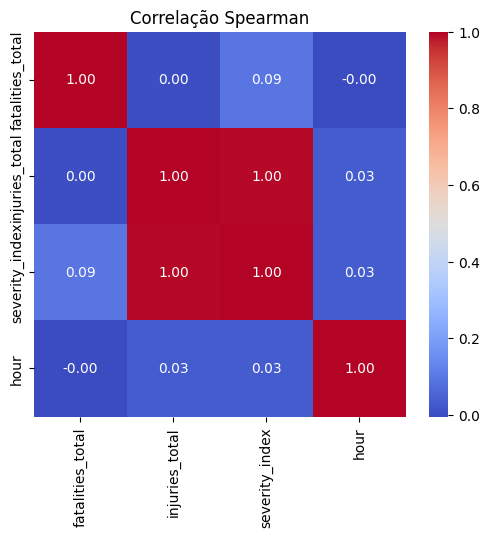

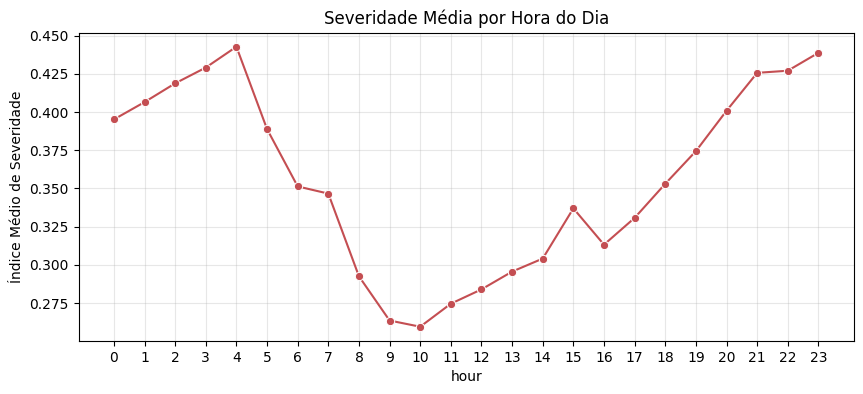

/tmp/ipykernel_37562/1185986204.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_stats, x='BOROUGH', y='severity_index', palette='magma')


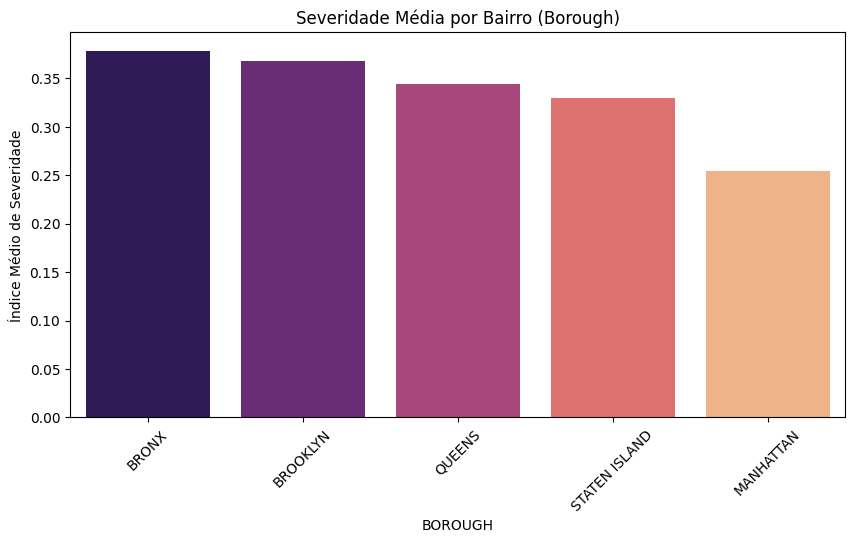

Estatísticas por Borough:
      BOROUGH  severity_index  fatalities_total  injuries_total  total_collisions
        BRONX          0.3783            0.0018          0.3692            331369
     BROOKLYN          0.3682            0.0015          0.3604            646019
       QUEENS          0.3437            0.0017          0.3352            626923
STATEN ISLAND          0.3293            0.0017          0.3207            115253
    MANHATTAN           0.254            0.0013          0.2475            446316


In [43]:
print("Análise Bivariada e Correlações")

# 1. Matriz de Correlação
cols_corr = ['fatalities_total', 'injuries_total', 'severity_index', 'hour']
corr = df_tidy_main[cols_corr].corr(method='spearman')

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação Spearman')
plt.show()

# 2. Severidade por hora
hour_stats = df_tidy_main.groupby('hour')[['severity_index', 'injuries_total', 'fatalities_total']].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=hour_stats, x='hour', y='severity_index', marker='o', color='#c44e52')
plt.title('Severidade Média por Hora do Dia')
plt.ylabel('Índice Médio de Severidade')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.show()

# 3. Severidade por bairro
borough_stats = df_tidy_main.groupby('BOROUGH').agg({
    'severity_index': 'mean',
    'fatalities_total': 'mean',
    'injuries_total': 'mean',
    'COLLISION_ID': 'count'
}).rename(columns={'COLLISION_ID': 'total_collisions'}).reset_index()

borough_stats = borough_stats.sort_values('severity_index', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=borough_stats, x='BOROUGH', y='severity_index', palette='magma')
plt.title('Severidade Média por Bairro (Borough)')
plt.xticks(rotation=45)
plt.ylabel('Índice Médio de Severidade')
plt.show()

print("Estatísticas por Borough:")
print(borough_stats.round(4).to_string(index=False))

## TESTE DE HIPOTESES

In [44]:
from scipy.stats import chi2_contingency

print("Teste de Hipóteses")

results = []

# H1: Letalidade Noturna (22h-05h)
df_tidy_main['is_night'] = df_tidy_main['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5])
df_tidy_main['has_fatality'] = df_tidy_main['fatalities_total'] > 0

# Teste Chi-Quadrado
tab_h1 = pd.crosstab(df_tidy_main['is_night'], df_tidy_main['has_fatality'])
chi2, p_val_h1, _, _ = chi2_contingency(tab_h1)

rate_night = tab_h1.loc[True, True] / tab_h1.loc[True].sum()
rate_day = tab_h1.loc[False, True] / tab_h1.loc[False].sum()

accepted_h1 = (p_val_h1 < 0.05) and (rate_night > rate_day)

results.append({
    'Hipótese': 'H1: Maior letalidade noturna',
    'Taxa A (Noite)': f"{rate_night*100:.3f}%",
    'Taxa B (Dia)': f"{rate_day*100:.3f}%",
    'P-Valor': p_val_h1,
    'Resultado': 'ACEITA' if accepted_h1 else 'REJEITADA'
})

# H2: Perfil Horário de Pico (07-09h, 17-19h)
peak_hours = [7, 8, 9, 17, 18, 19]
df_tidy_main['is_peak'] = df_tidy_main['hour'].isin(peak_hours)

h2_stats = df_tidy_main.groupby('is_peak')[['injuries_total', 'fatalities_total']].mean()

injuries_peak = h2_stats.loc[True, 'injuries_total']
injuries_off = h2_stats.loc[False, 'injuries_total']
fatal_peak = h2_stats.loc[True, 'fatalities_total']
fatal_off = h2_stats.loc[False, 'fatalities_total']

# Critério: Pico deve ter MAIS feridos e MENOS mortes (acidentes leves)
accepted_h2 = (injuries_peak > injuries_off) and (fatal_peak < fatal_off)

results.append({
    'Hipótese': 'H2: Pico (+Feridos / -Mortos)',
    'Taxa A (Pico)': f"Inj:{injuries_peak:.3f} | Fat:{fatal_peak:.4f}",
    'Taxa B (Fora)': f"Inj:{injuries_off:.3f} | Fat:{fatal_off:.4f}",
    'P-Valor': 'N/A',
    'Resultado': 'ACEITA' if accepted_h2 else 'REJEITADA'
})

# Resultado Final
print(pd.DataFrame(results).to_string(index=False))

if accepted_h1:
    print(f"\n[H1] A noite é {rate_night/rate_day:.1f}x mais letal que o dia.")
if accepted_h2:
    print("[H2] Horários de pico têm maior frequência de feridos, mas menor letalidade.")

Teste de Hipóteses
                     Hipótese Taxa A (Noite) Taxa B (Dia) P-Valor Resultado          Taxa A (Pico)          Taxa B (Fora)
 H1: Maior letalidade noturna         0.335%       0.116%     0.0    ACEITA                    NaN                    NaN
H2: Pico (+Feridos / -Mortos)            NaN          NaN     N/A REJEITADA Inj:0.320 | Fat:0.0012 Inj:0.333 | Fat:0.0018

[H1] A noite é 2.9x mais letal que o dia.


# Parte 4 

#### A ideia é treinar os modelos de machine learning (Regressão Linear e Random Forest) para predizer gravidade das colisões entre 0 = Sem vítimas, 1 = Leve (1-2 feridos),    2 = Moderado (3-5 feridos) e 3 = Grave (6+ feridos ou presença de mortos) isto baseado no dataset original limpo df_cleaned, e pensando nos atributos de tipo de veiculo, fatores contribuintes, bairros, e etc... 

In [45]:
df_cleaned

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DAY_OF_WEEK
0,2021-09-11,02:39:00,BRONX,N/A,33.967438,-61.553289,WHITESTONE EXPRESSWAY,20 AVENUE,N/A,2,...,Unspecified,Unspecified,Unspecified,4455765,Sedan,Sedan,N/A,N/A,N/A,Saturday
1,2022-03-26,11:45:00,MANHATTAN,N/A,40.757162,-73.955305,QUEENSBORO BRIDGE UPPER,N/A,N/A,1,...,Unspecified,Unspecified,Unspecified,4513547,Sedan,N/A,N/A,N/A,N/A,Saturday
2,2023-11-01,01:29:00,BROOKLYN,11230.0,40.621790,-73.970024,OCEAN PARKWAY,AVENUE K,N/A,1,...,Unspecified,Unspecified,Unspecified,4675373,Moped,Sedan,Sedan,N/A,N/A,Wednesday
3,2022-06-29,06:55:00,BRONX,N/A,40.808303,-73.797393,THROGS NECK BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4541903,Sedan,Pick-up Truck,N/A,N/A,N/A,Wednesday
4,2022-09-21,13:21:00,BROOKLYN,N/A,40.405489,-73.450636,BROOKLYN BRIDGE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,4566131,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212907,2016-10-09,09:30:00,STATEN ISLAND,10305.0,40.612595,-74.071655,N/A,N/A,254 CLIFTON AVENUE,0,...,Unspecified,Unspecified,Unspecified,3536789,Station Wagon/Sport Utility Vehicle,N/A,N/A,N/A,N/A,Sunday
2212908,2016-09-20,12:30:00,BROOKLYN,11229.0,40.610725,-73.955574,N/A,N/A,1804 AVENUE P,0,...,Unspecified,Unspecified,Unspecified,3527277,Sedan,Sedan,N/A,N/A,N/A,Tuesday
2212909,2016-09-19,13:00:00,BROOKLYN,N/A,40.611767,-73.976380,24 AVENUE,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,3523434,Sedan,N/A,N/A,N/A,N/A,Monday
2212910,2016-09-28,11:20:00,BROOKLYN,N/A,40.620560,-73.989440,63 STREET,N/A,N/A,0,...,Unspecified,Unspecified,Unspecified,3529408,Station Wagon/Sport Utility Vehicle,Pick-up Truck,N/A,N/A,N/A,Wednesday


In [46]:
df_cleaned['severity_score'] = (
    df_cleaned['NUMBER OF PERSONS INJURED'] + 
    10 * df_cleaned['NUMBER OF PERSONS KILLED']
)

def classify_severity(score):
    if score == 0:
        return 0  
    elif score <= 2:
        return 1  
    elif score <= 5:
        return 2  
    else:
        return 3 

df_cleaned['severity_class'] = df_cleaned['severity_score'].apply(classify_severity)

print("CLASSIFICAÇÃO DE SEVERIDADE")
print("\nDistribuição das classes:")
print(df_cleaned['severity_class'].value_counts().sort_index())
print("\nProporções:")
print(df_cleaned['severity_class'].value_counts(normalize=True).sort_index())
print(f"\nTotal de registros: {len(df_cleaned)}")

severity_names = {0: 'Sem Vítimas', 1: 'Leve', 2: 'Moderado', 3: 'Grave'}
print("\nCATEGORIAS")
for k, v in severity_names.items():
    count = (df_cleaned['severity_class'] == k).sum()
    pct = count / len(df_cleaned) * 100
    print(f"{k} - {v}: {count:,} ({pct:.2f}%)")


CLASSIFICAÇÃO DE SEVERIDADE

Distribuição das classes:
severity_class
0    1636491
1     485686
2      37692
3       6011
Name: count, dtype: int64

Proporções:
severity_class
0    0.755578
1    0.224244
2    0.017403
3    0.002775
Name: proportion, dtype: float64

Total de registros: 2165880

CATEGORIAS
0 - Sem Vítimas: 1,636,491 (75.56%)
1 - Leve: 485,686 (22.42%)
2 - Moderado: 37,692 (1.74%)
3 - Grave: 6,011 (0.28%)


In [47]:
# Preparar dados para ML - USANDO APENAS AS COLUNAS ORIGINAIS

numeric_features = ['LATITUDE',
                   'LONGITUDE']

# Features categóricas - SEM OS NOMES DE RUAS (causam explosão de memória!)
categorical_features = ['BOROUGH',
                       'ZIP CODE',
                       'DAY_OF_WEEK',
                       # REMOVIDO: 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME' 
                       # Motivo: milhares de valores únicos -> matriz gigante no OneHotEncoder
                       'CONTRIBUTING FACTOR VEHICLE 1', 
                       'CONTRIBUTING FACTOR VEHICLE 2',
                       'CONTRIBUTING FACTOR VEHICLE 3',
                       'CONTRIBUTING FACTOR VEHICLE 4',
                       'CONTRIBUTING FACTOR VEHICLE 5',
                       'VEHICLE TYPE CODE 1',
                       'VEHICLE TYPE CODE 2',
                       'VEHICLE TYPE CODE 3',
                       'VEHICLE TYPE CODE 4',
                       'VEHICLE TYPE CODE 5']

# Criar dataframe de trabalho
features = numeric_features + categorical_features
df_ml = df_cleaned[features + ['severity_class']].copy()

# Remover apenas linhas sem target
df_ml = df_ml.dropna(subset=['severity_class'])

print(f"USANDO APENAS COLUNAS ORIGINAIS (SEM NOMES DE RUAS)")
print(f"Shape total: {df_ml.shape}")
print(f"  - {len(features)} features + 1 target = {len(features) + 1} colunas")
print(f"Features numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")
print(f"\nREMOVIDAS: ON STREET NAME, CROSS STREET NAME, OFF STREET NAME")
print(f"   Motivo: Alta cardinalidade (>100k valores únicos) causa explosão de memória")
print(f"\nValores nulos por coluna:")
print(df_ml.isnull().sum())
print(f"\nDistribuição do target (severity_class):")
print(df_ml['severity_class'].value_counts().sort_index())


USANDO APENAS COLUNAS ORIGINAIS (SEM NOMES DE RUAS)
Shape total: (2165880, 16)
  - 15 features + 1 target = 16 colunas
Features numéricas: 2
Features categóricas: 13

REMOVIDAS: ON STREET NAME, CROSS STREET NAME, OFF STREET NAME
   Motivo: Alta cardinalidade (>100k valores únicos) causa explosão de memória

Valores nulos por coluna:
LATITUDE                         0
LONGITUDE                        0
BOROUGH                          0
ZIP CODE                         0
DAY_OF_WEEK                      0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
CONTRIBUTING FACTOR VEHICLE 3    0
CONTRIBUTING FACTOR VEHICLE 4    0
CONTRIBUTING FACTOR VEHICLE 5    0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
VEHICLE TYPE CODE 3              0
VEHICLE TYPE CODE 4              0
VEHICLE TYPE CODE 5              0
severity_class                   0
dtype: int64

Distribuição do target (severity_class):
severity_class
0    1636491
1     485686
2      37

In [48]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False))
])

# Preprocessador para features categóricas: esparso e colapsa categorias raras
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(
        sparse_output=True,
        handle_unknown='infrequent_if_exist',
        min_frequency=50,

    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=1.0
)
print("Preprocessador ajustado: OneHot esparso + min_frequency=50")

Preprocessador ajustado: OneHot esparso + min_frequency=50


#### Divisão de Treino e Teste

In [49]:
# X e y a partir de df_ml e lista de features já definidas
X = df_ml[features]
y = df_ml['severity_class']

# Estratificar para manter proporção de severidade
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")
print("Distribuição treino:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nDistribuição teste:")
print(y_test.value_counts(normalize=True).sort_index())


Treino: (1732704, 15), Teste: (433176, 15)
Distribuição treino:
severity_class
0    0.755578
1    0.224244
2    0.017402
3    0.002775
Name: proportion, dtype: float64

Distribuição teste:
severity_class
0    0.755577
1    0.224244
2    0.017404
3    0.002775
Name: proportion, dtype: float64


### Modelo 1: Regressão Linear (BASE)

In [50]:
# Regressão Linear Ordinal para Severidade (corrigido RMSE)
linreg = LinearRegression()
linreg_pipeline = Pipeline(steps=[('pre', preprocessor), ('linreg', linreg)])

start = time.time()
linreg_pipeline.fit(X_train, y_train)
train_time = time.time() - start

y_pred_cont = linreg_pipeline.predict(X_test)
y_pred_round = np.clip(np.round(y_pred_cont), 0, 3).astype(int)

acc = accuracy_score(y_test, y_pred_round)
f1w = f1_score(y_test, y_pred_round, average='weighted', zero_division=0)
f1m = f1_score(y_test, y_pred_round, average='macro', zero_division=0)
mae = mean_absolute_error(y_test, y_pred_cont)
mse = mean_squared_error(y_test, y_pred_cont)
rmse = np.sqrt(mse)

print('REGRESSAO LINEAR (ORDINAL) SEVERITY')
print(f'Tempo de treinamento: {train_time:.2f}s')
print(f'Acurácia (classe após arredondar): {acc:.4f}')
print(f'F1-Score (macro): {f1m:.4f}')
print(f'F1-Score (weighted): {f1w:.4f}')
print(f'MAE (contínuo): {mae:.4f}  RMSE (contínuo): {rmse:.4f}')

print('\nClassification Report (após arredondar):')
print(classification_report(y_test, y_pred_round, digits=3, zero_division=0))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_round))


REGRESSAO LINEAR (ORDINAL) SEVERITY
Tempo de treinamento: 42.70s
Acurácia (classe após arredondar): 0.7953
F1-Score (macro): 0.3349
F1-Score (weighted): 0.7664
MAE (contínuo): 0.3270  RMSE (contínuo): 0.4531

Classification Report (após arredondar):
              precision    recall  f1-score   support

           0      0.818     0.945     0.877    327298
           1      0.639     0.362     0.462     97137
           2      0.026     0.000     0.000      7539
           3      0.000     0.000     0.000      1202

    accuracy                          0.795    433176
   macro avg      0.371     0.327     0.335    433176
weighted avg      0.762     0.795     0.766    433176

Confusion Matrix:
[[309341  17952      5      0]
 [ 61922  35184     31      0]
 [  6133   1405      1      0]
 [   698    503      1      0]]


## Tentativa de Distribuir peso por classes

**Problema**: Classes 2 (Moderado) e 3 (Grave) são raríssimas (~2% e <1%)
**Solução**: Penalizar MUITO mais os erros nessas classes para forçar o modelo a detectá-las

In [51]:
# Calcular distribuição das classes para entender o desbalanceamento
print("DISTRIBUIÇÃO DAS CLASSES")
print(y_train.value_counts().sort_index())
print("\n Proporção (%):")
print(y_train.value_counts(normalize=True).sort_index() * 100)

# 1. CLASS WEIGHT PADRÃO 'balanced' (sklearn automático)
class_weights_balanced = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
cw_balanced_dict = dict(zip(np.unique(y_train), class_weights_balanced))

print("\nCLASS WEIGHT 'balanced' (automático)")
for cls, weight in cw_balanced_dict.items():
    print(f"Classe {cls}: peso = {weight:.2f}")

# 2. CLASS WEIGHT CUSTOMIZADO 

n_samples = len(y_train)
class_counts = y_train.value_counts().sort_index()

multipliers = {
    0: 1.0,    
    1: 1.0,    
    2: 1.2,    
    3: 1.5     
}

custom_weights = {}
for cls in sorted(class_counts.index):
    base_weight = n_samples / (len(class_counts) * class_counts[cls])
    custom_weights[cls] = base_weight * multipliers[cls]

print("\nCLASS WEIGHT CUSTOMIZADO (MODERADO - ajustado)")
for cls, weight in custom_weights.items():
    severity_name = ['Sem Vítimas', 'Leve', 'Moderado', 'Grave'][cls]
    print(f"Classe {cls} ({severity_name}): peso = {weight:.2f} (multiplicador {multipliers[cls]}x)")

print("\nPesos mais equilibrados: reduzir classe 0, aumentar 2 e 3 moderadamente")
print("   Estratégia: penalizar maioria, privilegiar minorias sem exagero")


DISTRIBUIÇÃO DAS CLASSES
severity_class
0    1309193
1     388549
2      30153
3       4809
Name: count, dtype: int64

 Proporção (%):
severity_class
0    75.557799
1    22.424430
2     1.740228
3     0.277543
Name: proportion, dtype: float64

CLASS WEIGHT 'balanced' (automático)
Classe 0: peso = 0.33
Classe 1: peso = 1.11
Classe 2: peso = 14.37
Classe 3: peso = 90.08

CLASS WEIGHT CUSTOMIZADO (MODERADO - ajustado)
Classe 0 (Sem Vítimas): peso = 0.33 (multiplicador 1.0x)
Classe 1 (Leve): peso = 1.11 (multiplicador 1.0x)
Classe 2 (Moderado): peso = 17.24 (multiplicador 1.2x)
Classe 3 (Grave): peso = 135.11 (multiplicador 1.5x)

Pesos mais equilibrados: reduzir classe 0, aumentar 2 e 3 moderadamente
   Estratégia: penalizar maioria, privilegiar minorias sem exagero


# Otimização de hiperparâmetros por meio de Ridge

In [52]:
# 1. CRIAR SAMPLE WEIGHTS baseado nos custom_weights
# Mapear cada amostra de treino para seu peso correspondente
sample_weights = np.array([custom_weights[int(y)] for y in y_train])

print(f"Sample weights criados: {len(sample_weights)} amostras")
print(f"Pesos únicos: {np.unique(sample_weights)}")
print(f"Distribuição de pesos:")
for cls in sorted(custom_weights.keys()):
    count = np.sum(y_train == cls)
    weight = custom_weights[cls]
    print(f"  Classe {cls}: {count} amostras x peso {weight:.2f} = impacto total {count*weight:.0f}")

# Grid de hiperparâmetros para Ridge
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]  # Sem 'linreg__' pois não está em pipeline aqui
}

# 2. SCORER CUSTOMIZADO com pesos (penaliza mais erros em classes raras)
def weighted_ordinal_f1_macro(y_true, y_pred_cont, sample_weight=None):
    y_pred_round = np.clip(np.round(y_pred_cont), 0, 3).astype(int)
    return f1_score(y_true, y_pred_round, average='macro', zero_division=0, sample_weight=sample_weight)

# Criar scorer que aceita sample_weight
scorer = make_scorer(weighted_ordinal_f1_macro, greater_is_better=True)

# 3. TREINAR com GridSearchCV passando sample_weight no fit
print("\nExecutando GridSearchCV para Ridge com SAMPLE_WEIGHT customizado...")

# Preprocessar dados manualmente (porque vamos usar Ridge direto, não Pipeline)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# GridSearchCV com Ridge
ridge_model = Ridge()
grid_search_weighted = GridSearchCV(
    ridge_model,
    param_grid,
    scoring=scorer,
    cv=2,
    n_jobs=2,
    verbose=1
)

start = time.time()
# AQUI: passa sample_weight no fit
grid_search_weighted.fit(X_train_processed, y_train, sample_weight=sample_weights)
train_time = time.time() - start

print(f"\nRIDGE COM SAMPLE_WEIGHT CUSTOMIZADO")
print(f"Tempo: {train_time:.2f}s")
print(f"Melhor alpha: {grid_search_weighted.best_params_}")
print(f"Melhor F1-macro (CV): {grid_search_weighted.best_score_:.4f}")

# 4. AVALIAR no teste
best_ridge_weighted = grid_search_weighted.best_estimator_
y_pred_cont_weighted = best_ridge_weighted.predict(X_test_processed)
y_pred_round_weighted = np.clip(np.round(y_pred_cont_weighted), 0, 3).astype(int)

acc_w = accuracy_score(y_test, y_pred_round_weighted)
f1m_w = f1_score(y_test, y_pred_round_weighted, average='macro', zero_division=0)
f1w_w = f1_score(y_test, y_pred_round_weighted, average='weighted', zero_division=0)
mae_w = mean_absolute_error(y_test, y_pred_cont_weighted)
rmse_w = np.sqrt(mean_squared_error(y_test, y_pred_cont_weighted))

print(f"\nDesempenho no Teste:")
print(f"Acurácia: {acc_w:.4f}")
print(f"F1-macro: {f1m_w:.4f}")
print(f"F1-weighted: {f1w_w:.4f}")
print(f"MAE: {mae_w:.4f}  RMSE: {rmse_w:.4f}")

print('\nClassification Report:')
print(classification_report(y_test, y_pred_round_weighted, target_names=['Sem Vítimas', 'Leve', 'Moderado', 'Grave'], digits=3, zero_division=0))

print('Confusion Matrix:')
cm_ridge_weighted = confusion_matrix(y_test, y_pred_round_weighted)
print(cm_ridge_weighted)


Sample weights criados: 1732704 amostras
Pesos únicos: [  0.33087253   1.11485553  17.23912049 135.11416095]
Distribuição de pesos:
  Classe 0: 1309193 amostras x peso 0.33 = impacto total 433176
  Classe 1: 388549 amostras x peso 1.11 = impacto total 433176
  Classe 2: 30153 amostras x peso 17.24 = impacto total 519811
  Classe 3: 4809 amostras x peso 135.11 = impacto total 649764

Executando GridSearchCV para Ridge com SAMPLE_WEIGHT customizado...
Fitting 2 folds for each of 4 candidates, totalling 8 fits

RIDGE COM SAMPLE_WEIGHT CUSTOMIZADO
Tempo: 98.62s
Melhor alpha: {'alpha': 0.1}
Melhor F1-macro (CV): 0.2541

Desempenho no Teste:
Acurácia: 0.1466
F1-macro: 0.1121
F1-weighted: 0.1344
MAE: 1.1407  RMSE: 1.2597

Classification Report:
              precision    recall  f1-score   support

 Sem Vítimas      0.950     0.056     0.105    327298
        Leve      0.168     0.421     0.240     97137
    Moderado      0.025     0.553     0.048      7539
       Grave      0.034     0.143  

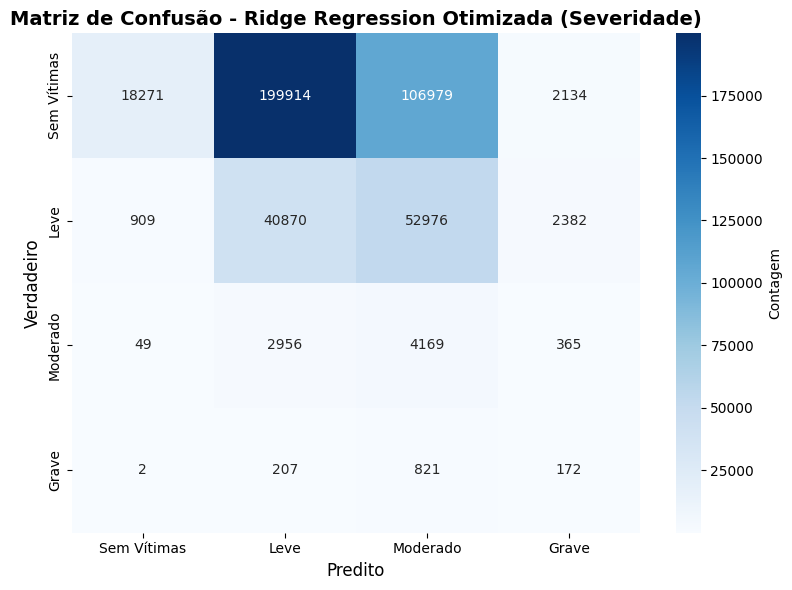

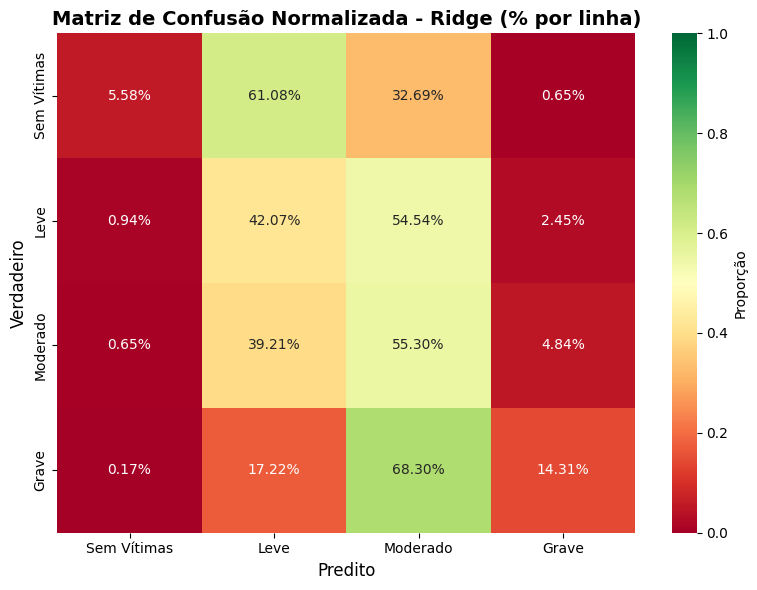

In [53]:
#Matriz de Confusão para Ridge 

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge_weighted, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sem Vítimas', 'Leve', 'Moderado', 'Grave'],
            yticklabels=['Sem Vítimas', 'Leve', 'Moderado', 'Grave'],
            cbar_kws={'label': 'Contagem'})
plt.title('Matriz de Confusão - Ridge Regression Otimizada (Severidade)', fontsize=14, fontweight='bold')
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Verdadeiro', fontsize=12)
plt.tight_layout()
plt.show()

# Matriz normalizada por linha (recall por classe)
cm_ridge_norm = cm_ridge_weighted.astype('float') / cm_ridge_weighted.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge_norm, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=['Sem Vítimas', 'Leve', 'Moderado', 'Grave'],
            yticklabels=['Sem Vítimas', 'Leve', 'Moderado', 'Grave'],
            cbar_kws={'label': 'Proporção'}, vmin=0, vmax=1)
plt.title('Matriz de Confusão Normalizada - Ridge (% por linha)', fontsize=14, fontweight='bold')
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Verdadeiro', fontsize=12)
plt.tight_layout()
plt.show()


### Modelo 2: Random Forest (BASE)

In [54]:
# Criar pipeline com Random Forest (multi-classe)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=20,
                                         class_weight='balanced', random_state=42, n_jobs=-1))
])

# Treinar modelo
print("Treinando Random Forest (multi-classe)...")
start = time.time()
rf_pipeline.fit(X_train, y_train)
train_time = time.time() - start

# Predições
y_pred_rf = rf_pipeline.predict(X_test)

# Avaliar
print(f"\nRANDOM FOREST (SEVERITY)")
print(f"Tempo de treinamento: {train_time:.2f}s")
print(f"\nAcurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Sem Vítimas', 'Leve', 'Moderado', 'Grave']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Treinando Random Forest (multi-classe)...



RANDOM FOREST (SEVERITY)
Tempo de treinamento: 469.01s

Acurácia: 0.5508
F1-Score (macro): 0.3159
F1-Score (weighted): 0.6363

Classification Report:
              precision    recall  f1-score   support

 Sem Vítimas       0.89      0.59      0.70    327298
        Leve       0.48      0.44      0.46     97137
    Moderado       0.04      0.59      0.07      7539
       Grave       0.01      0.22      0.03      1202

    accuracy                           0.55    433176
   macro avg       0.35      0.46      0.32    433176
weighted avg       0.78      0.55      0.64    433176


Confusion Matrix:
[[191616  45294  79029  11359]
 [ 22182  42295  27048   5612]
 [  2327    417   4440    355]
 [   181    337    424    260]]


### Modelo 3: MLP (Multi-Layer Perceptron) (BASE)

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import time

# Criar pipeline com MLP para severity multi-classe
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, 
                                random_state=42, early_stopping=True, verbose=False))
])

# Treinar modelo
print("Treinando MLP (multi-classe)...")
start = time.time()
mlp_pipeline.fit(X_train, y_train)
train_time = time.time() - start

# Predições
y_pred_mlp = mlp_pipeline.predict(X_test)

# Avaliar
print(f"\nMLP (MULTI-LAYER PERCEPTRON - SEVERITY)")
print(f"Tempo de treinamento: {train_time:.2f}s")
print(f"\nAcurácia: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred_mlp, average='macro', zero_division=0):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_mlp, average='weighted', zero_division=0):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=['Sem Vítimas', 'Leve', 'Moderado', 'Grave'], digits=3, zero_division=0))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))


#### Otimizando hiperparâmetros do Random Forest

In [55]:
# Random Forest com Amostragem 
# 1) Definido o tamanho da amostra estratificada para 200k de amostras
SAMPLE_SIZE = 200_000

# Garantir que não ultrapasse o tamanho do treino
n_train = len(y_train)
sample_size = min(SAMPLE_SIZE, n_train)

print(f"Amostragem estratificada em {sample_size} exemplos do treino (de {n_train}).")

sss = StratifiedShuffleSplit(n_splits=1, test_size=n_train - sample_size, random_state=42)
for train_idx, _ in sss.split(X_train, y_train):
    X_train_small = X_train.iloc[train_idx] if hasattr(X_train, 'iloc') else X_train[train_idx]
    y_train_small = y_train.iloc[train_idx] if hasattr(y_train, 'iloc') else y_train[train_idx]

# 2) Pipeline com RandomForest usando bootstrap + max_samples (subamostragem por árvore)
# max_samples controla quantos exemplos cada árvore vê -> acelera bastante
rf_fast = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=30,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced_subsample',
        bootstrap=True,
        max_samples=50_000,   # cada árvore treina com no máx. 50k exemplos
        n_jobs=2,
        random_state=42
    ))
])

scorer = make_scorer(f1_score, average='macro', zero_division=0)

# 3) Pequeno GridSearchCV sobre poucos parâmetros, usando a amostra menor
param_grid_fast = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [20, 30],
    'classifier__max_samples': [30_000, 50_000],
}

print("Executando GridSearchCV rápido (amostra estratificada + max_samples)...")
start = time.time()

grid_search_fast = GridSearchCV(
    rf_fast,
    param_grid_fast,
    scoring=scorer,
    cv=2,
    n_jobs=2,
    verbose=2,
    return_train_score=False
)

grid_search_fast.fit(X_train_small, y_train_small)
train_time = time.time() - start

print(f"Tempo total treino rápido: {train_time:.2f}s ({train_time/60:.1f} min)")
print("Melhores parâmetros (rápido):")
for k, v in grid_search_fast.best_params_.items():
    print(f"  {k}: {v}")
print(f"Melhor F1-macro (CV amostra): {grid_search_fast.best_score_:.4f}")

# 4) Avaliar no conjunto de teste completo
best_rf_fast = grid_search_fast.best_estimator_
y_pred_fast = best_rf_fast.predict(X_test)

acc = accuracy_score(y_test, y_pred_fast)
f1m = f1_score(y_test, y_pred_fast, average='macro', zero_division=0)
f1w = f1_score(y_test, y_pred_fast, average='weighted', zero_division=0)

print("\nDesempenho no teste (modelo rápido):")
print(f"Acurácia: {acc:.4f}")
print(f"F1-macro: {f1m:.4f}")
print(f"F1-weighted: {f1w:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_fast,
                           target_names=['Sem Vítimas','Leve','Moderado','Grave'],
                           digits=3, zero_division=0))

cm = confusion_matrix(y_test, y_pred_fast)
print("\nConfusion Matrix:")
print(cm)
if cm[0,:].sum() > 0 :
    print(f"Sem Vítimas detectados: {cm[0,0]}/{cm[0,:].sum()} ({cm[0,0]/cm[0,:].sum()*100:.1f}%)")
if cm[1,:].sum() > 0 :
    print(f"Leve detectados: {cm[1,1]}/{cm[1,:].sum()} ({cm[1,1]/cm[1,:].sum()*100:.1f}%)")
if cm[2,:].sum() > 0:
    print(f"Moderado detectados: {cm[2,2]}/{cm[2,:].sum()} ({cm[2,2]/cm[2,:].sum()*100:.1f}%)")
if cm[3,:].sum() > 0:
    print(f"Grave detectados: {cm[3,3]}/{cm[3,:].sum()} ({cm[3,3]/cm[3,:].sum()*100:.1f}%)")


Amostragem estratificada em 200000 exemplos do treino (de 1732704).
Executando GridSearchCV rápido (amostra estratificada + max_samples)...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END classifier__max_depth=20, classifier__max_samples=30000, classifier__n_estimators=200; total time=   9.6s
[CV] END classifier__max_depth=20, classifier__max_samples=30000, classifier__n_estimators=200; total time=   9.9s
[CV] END classifier__max_depth=20, classifier__max_samples=30000, classifier__n_estimators=300; total time=  16.0s
[CV] END classifier__max_depth=20, classifier__max_samples=30000, classifier__n_estimators=300; total time=  15.6s
[CV] END classifier__max_depth=20, classifier__max_samples=50000, classifier__n_estimators=200; total time=  12.6s
[CV] END classifier__max_depth=20, classifier__max_samples=50000, classifier__n_estimators=200; total time=  12.9s
[CV] END classifier__max_depth=20, classifier__max_samples=50000, classifier__n_estimators=300; total time=  1